# Задача
1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

# Решение

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Регулярные выражения
import re

# Расширение имен файлов по маске
import glob

# Копирование файлов
import shutil

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [ ]:
# Скачиваем архив с данными
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip')

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip
To: /content/dataverse_files.zip
100%|██████████| 224M/224M [00:22<00:00, 10.0MB/s]


'dataverse_files.zip'

In [ ]:
# Распаковка архива
!unzip -qo dataverse_files.zip -d dataverse_files

## Работа с данными

In [ ]:
# Константы
CLASS_LIST = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
CLASS_COUNT = len(CLASS_LIST)
CLASS_FILES = 400                         # Общее количество файлов в каждом классе

FILE_DIR = './dataverse_files'

FILE_INDEX_TRAIN_SPLIT = 350              # Количество файлов каждого класса на основной набор
DURATION_SEC = 1                          # Анализируемая длительность аудиосигнала (в секундах)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 256                          # Объем данных для расчета одного набора признаков
SEQ_LENGTH = 50                           # Размер последовательности при нарезке
SEQ_HOP_LENGTH = 10                       # Размер шага нарезки последовательностей

### DATA_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']
DATA_NAMES = {CLASS_LIST[i] : [] for i in range(CLASS_COUNT)}

In [ ]:
FILE_NAMES = os.listdir(FILE_DIR)

for class_name in CLASS_LIST:
    for name in FILE_NAMES:
        if class_name in name:
            DATA_NAMES[class_name].append(name)

In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)

    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_name,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    for class_indexes, class_names in enumerate(CLASS_LIST):
        if class_names == class_name:
            class_index = class_indexes

    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

Функция с урока с дополнением: по каждому файлу собирается набор векторов признаков и затем нарезается на последовательности в соответствии с заданными гиперпараметрами. Каждой последовательности сопоставляется правильная метка класса:

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_name,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []

    if file_index >= 400:
        FILE_DIR = './SAVEE/ALL'
    else:
        FILE_DIR = './dataverse_files'

    # Извлечение имени произведения
    if isinstance(class_name, int):
        class_name = CLASS_LIST[class_name]
    song_name = f'{FILE_DIR}/{DATA_NAMES[class_name][file_index]}'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_name, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы: нарезка набора признаков файла на последовательности
    feature_len = feature_set.shape[0]
    x_list = [feature_set[i:i+SEQ_LENGTH] for i in range(0, feature_len - SEQ_LENGTH + 1, SEQ_HOP_LENGTH)]
    
    # Добавление верных меток класса по числу последовательностей
    y_list = [y_label] * len(x_list)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()


    # Для всех классов:
    for class_name in CLASS_LIST:
        
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_name, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        for class_indexes, class_names in enumerate(CLASS_LIST):
            if class_names == class_name:
                class_index = class_indexes
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

print(x_train_data.shape, y_train_data.shape)

Жанр angry готов -> 38 c
Жанр disgust готов -> 36 c
Жанр fear готов -> 35 c
Жанр happy готов -> 35 c
Жанр neutral готов -> 36 c
Жанр ps готов -> 37 c
Жанр sad готов -> 38 c
(9800, 50, 25) (9800, 7)


In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов


with open('/content/audio_data_mean.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

with open('/content/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

Проверяем метки классов в наборе: поскольку классы обрабатывались один за другим, метки классов в наборе y_train будут следовать в том же порядке:

In [ ]:
# Вывод номеров классов для проверки правильности заполнения
# Номера классов идут последовательно крупными блоками
print(np.argmax(y_train_data, axis=1))

[0 0 0 ... 6 6 6]


In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(9800, 50, 25) float32
(9800, 7) float32


---

**Нормализация** при формировании данных  в этом решении не применяется - она произойдет в классификаторе перед первым слоем  нейронов.

---


Сформируем данные для теста из файлов тестового набора - код в точности тот же, что и на уроке:

In [ ]:
# Формирование тестовой выборки из файлов, не вошедших в основной набор
x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)

Жанр angry готов -> 4 c
Жанр disgust готов -> 5 c
Жанр fear готов -> 4 c
Жанр happy готов -> 4 c
Жанр neutral готов -> 6 c
Жанр ps готов -> 4 c
Жанр sad готов -> 4 c


Будем использовать полный тренировочный набор данных, в качестве проверочного возьмем тестовый. Это обоснованно, потому что отбирать данные для проверки правильнее целиком из отдельных (тестовых) файлов, а не по кусочкам из разных мест основного набора:

In [ ]:
# В качестве обучающей выборки используется весь обучающий набор данных

x_train = x_train_data
y_train = y_train_data

In [ ]:
# Проверка формы и типа данных обучающей и тестовой выборок

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(9800, 50, 25) float32
(9800, 7) float32

(1400, 50, 25) float32
(1400, 7) float32


## Сервисные функции

Функция вывода графиков точности и ошибки по эпохам обучения

In [ ]:
# Вывод графиков точности и ошибки распознавания на обучающей и проверочной выборках

def show_history(history  # объект-результат метода обучения .fit()
                 ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

Функции визуализации распознавания - как на уроке, исключен объект x_scaler:

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель классификатора
               x,      # входные данные для предсказаний модели
               y_true  # выходные данные (верные ответы)
               ):
    
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)

    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)

    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса 

def classify_test_files(model,       # обученная модель классификатора
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')   

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

## Модель Conv1D

Составим сверточный классификатор из трех блоков сверток, с использованием макспулинга и пакетной нормализации.

Нормализация данных нужна особенно в начале модели, поскольку данные не были нормализованы ранее.

In [ ]:
def create_model():
    # Последовательная модель нейронной сети
    model = Sequential()
    
    # Входной слой
    model.add(Input(shape=x_train.shape[1:]))

    # Первый сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(256, (3,), activation='relu'))
    model.add(Conv1D(256, (3,), activation='relu'))
    model.add(MaxPooling1D(2))

    # Второй сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(512, (3,), activation='relu'))
    model.add(Conv1D(512, (3,), activation='relu'))
    model.add(MaxPooling1D(3))

    # Третий сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(1024, (2,), activation='relu'))
    model.add(Conv1D(1024, (2,), activation='relu'))
    model.add(MaxPooling1D(2))

    # Полносвязный блок
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    # Финальный слой классификации
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    return model

Обучим классификатор, подобрав параметры обучения. Выведем графики обучения:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 25)           100       
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 48, 256)           19456     
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 256)           196864    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 256)          0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 23, 256)          1024      
 hNormalization)                                                 
                                                        

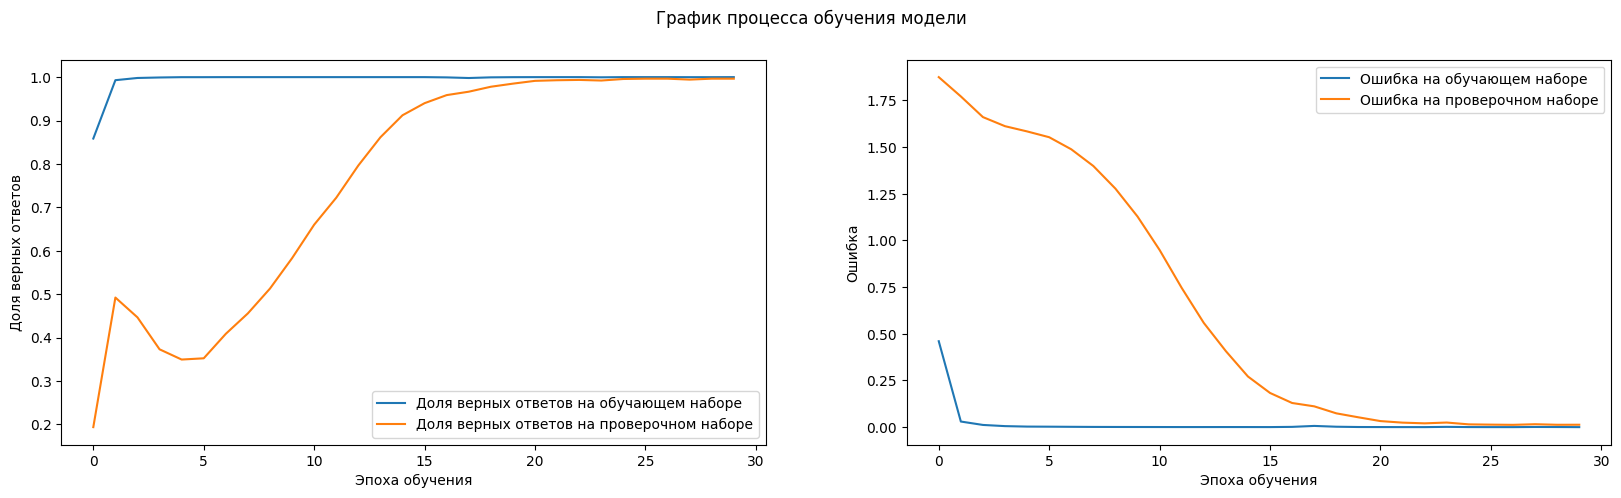

In [ ]:
# Задание параметров обучения
EPOCHS      = 30
BATCH_SIZE  = 512

# Создание модели
model = create_model()
model.summary()

# Компиляция
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение
history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    verbose=1)

# Отрисовка графиков ошибки и точности
show_history(history)

## Тестирование модели

Возможно, наблюдается небольшой эффект переобучения.

Проведем оценку модели на тестовых данных так же, как на уроке:

44/44 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.9964
Ошибка: 0.013055509887635708, точность: 0.9964285492897034
44/44 [==============================] - 0s 3ms/step


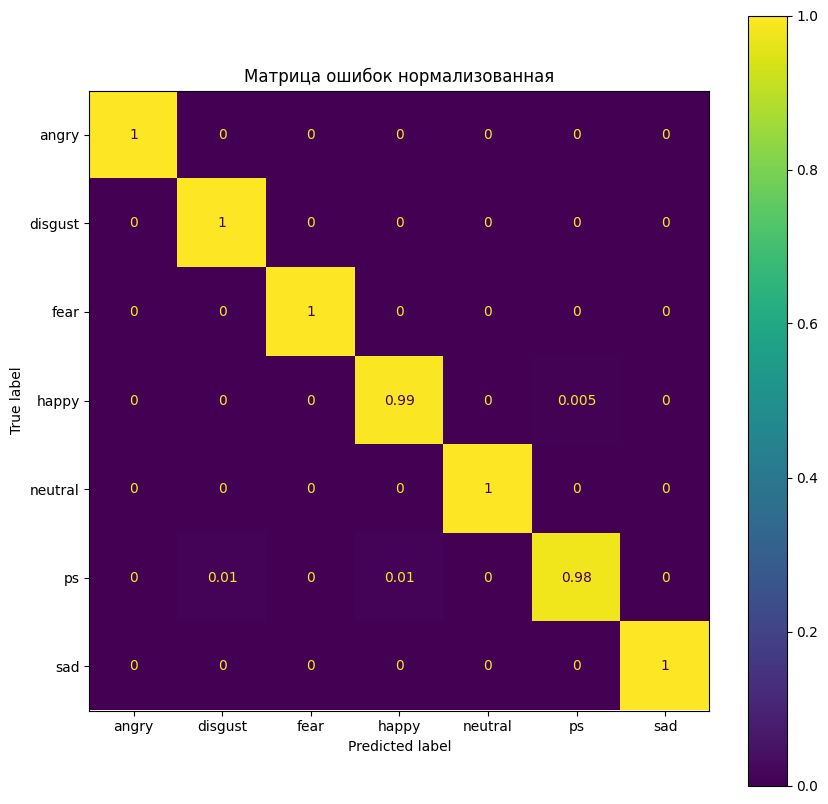

In [ ]:
# Оценка работы модели на тестовых данных

eval_model(model, x_test, y_test)

Оценим работу модели на всех звуковых файлах тестового набора так же, как на уроке:

Файл: ./dataverse_files/YAF_five_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 128ms/step
Классификация сети: angry - ВЕРНО :-)


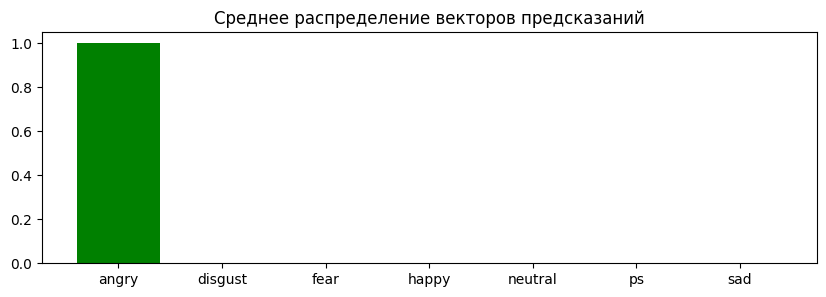

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_bone_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: angry - ВЕРНО :-)


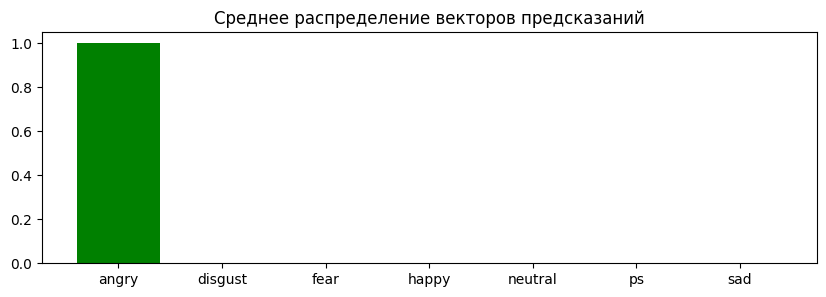

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_dip_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: angry - ВЕРНО :-)


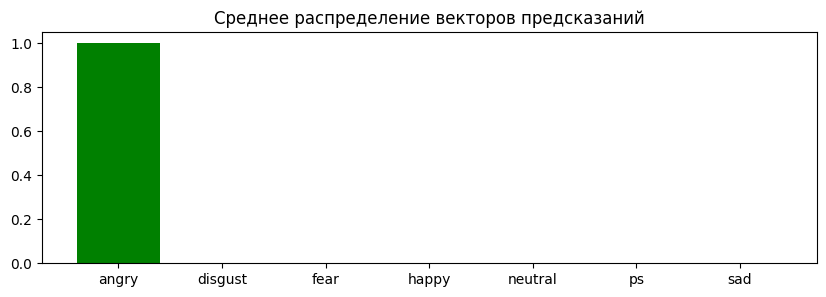

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_yearn_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: angry - ВЕРНО :-)


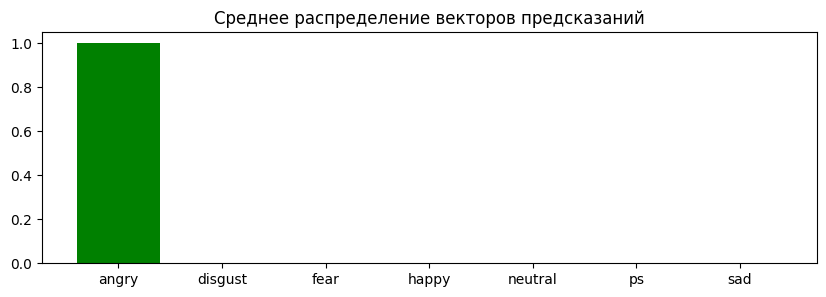

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_cab_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: angry - ВЕРНО :-)


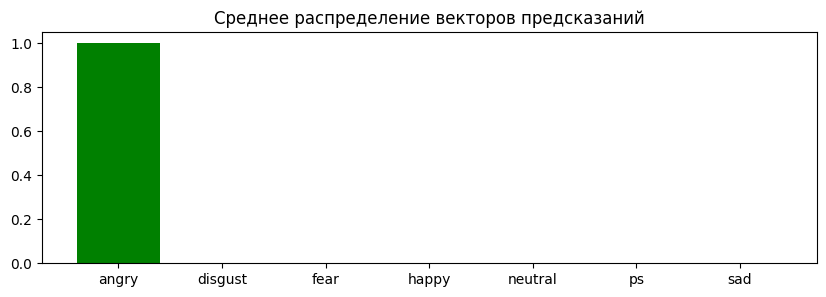

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_good_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: angry - ВЕРНО :-)


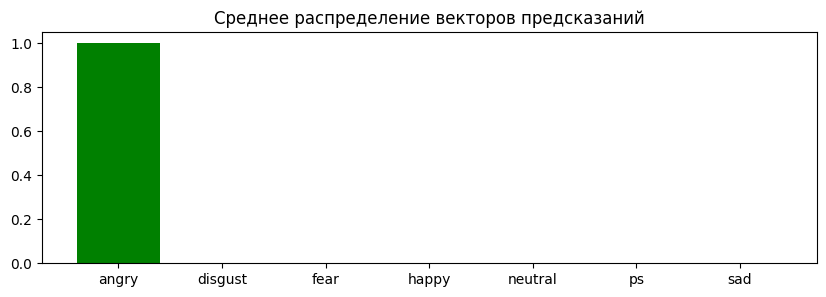

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_nag_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: angry - ВЕРНО :-)


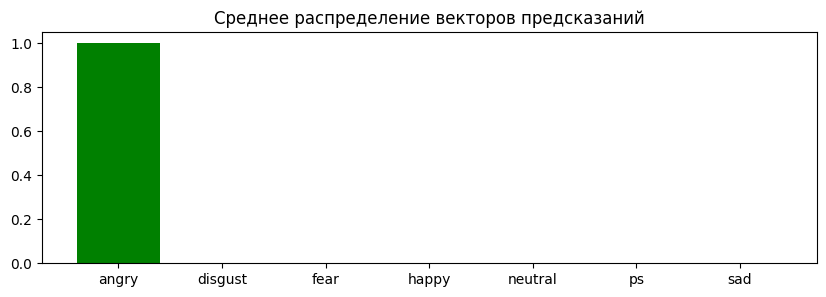

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_chain_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: angry - ВЕРНО :-)


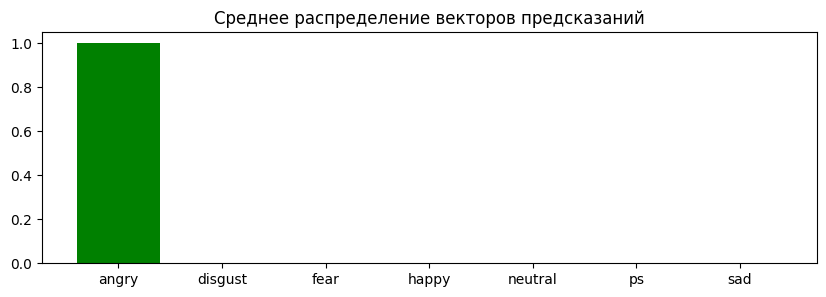

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_such_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: angry - ВЕРНО :-)


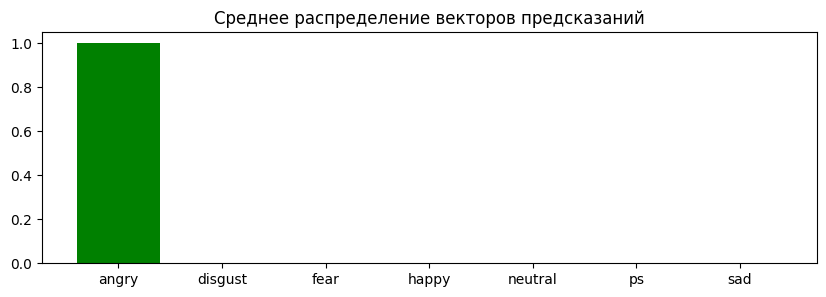

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_ton_angry.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: angry - ВЕРНО :-)


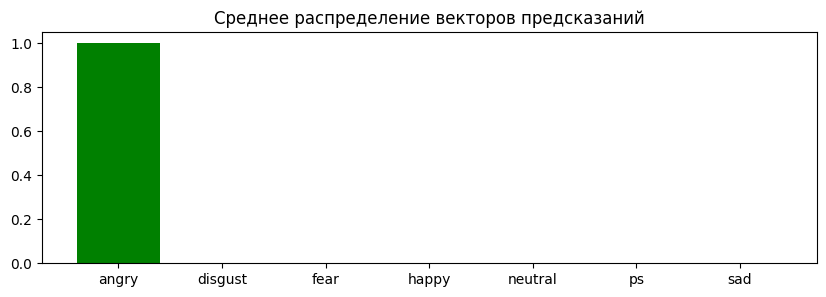

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_jail_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: disgust - ВЕРНО :-)


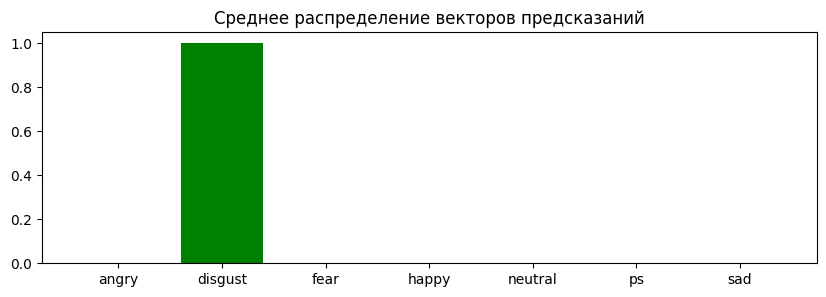

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_gaze_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: disgust - ВЕРНО :-)


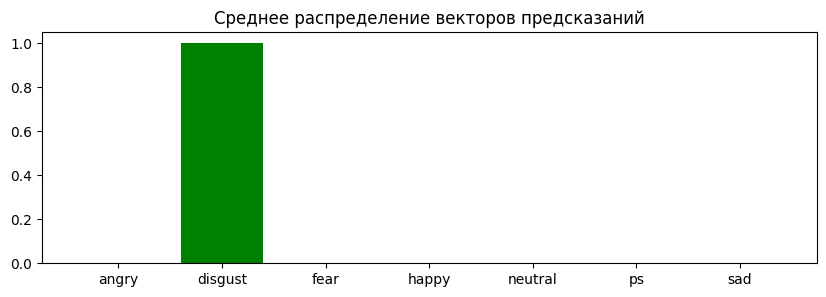

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_loaf_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: disgust - ВЕРНО :-)


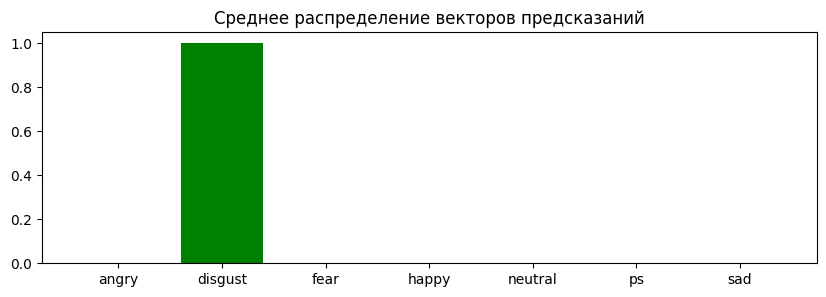

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_ripe_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: disgust - ВЕРНО :-)


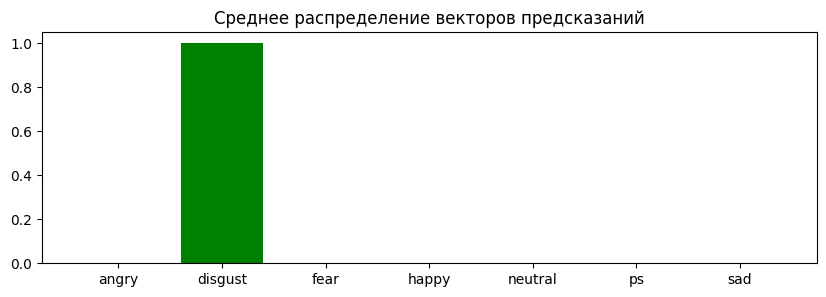

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_deep_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: disgust - ВЕРНО :-)


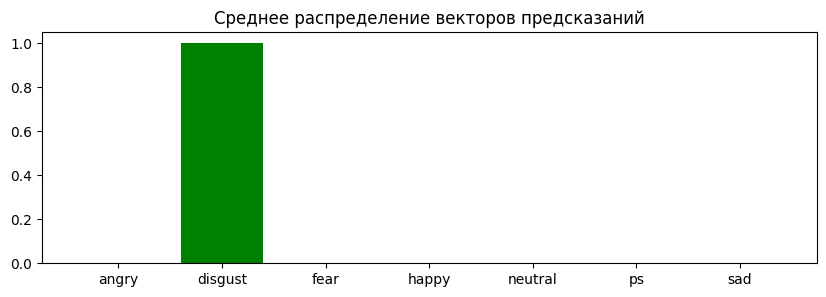

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_pole_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: disgust - ВЕРНО :-)


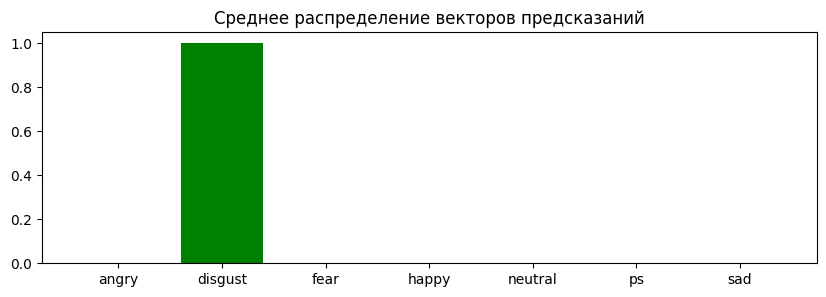

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_chief_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: disgust - ВЕРНО :-)


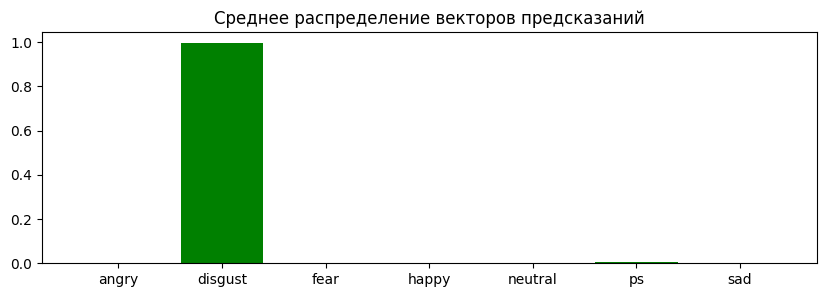

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_nice_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: disgust - ВЕРНО :-)


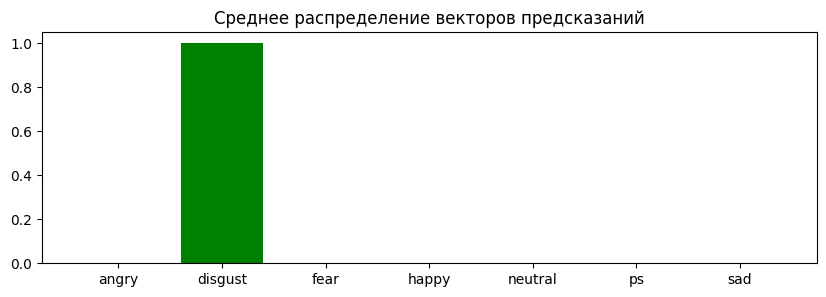

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_fall_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: disgust - ВЕРНО :-)


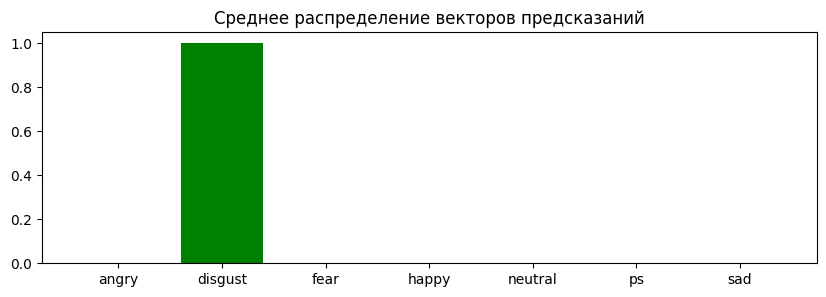

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_bar_disgust.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 39ms/step
Классификация сети: disgust - ВЕРНО :-)


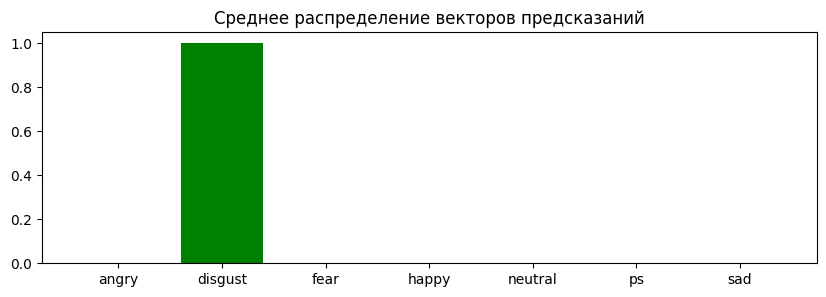

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_moon_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 39ms/step
Классификация сети: fear - ВЕРНО :-)


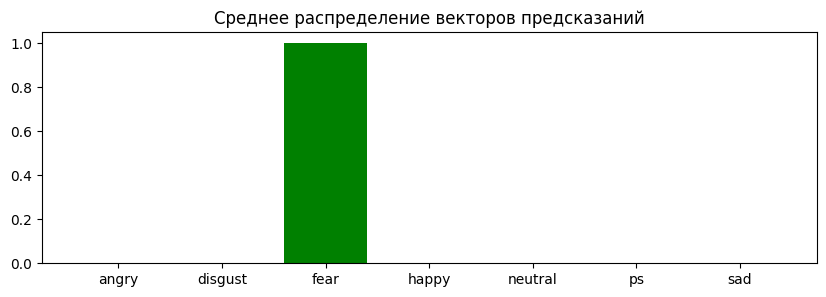

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_base_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: fear - ВЕРНО :-)


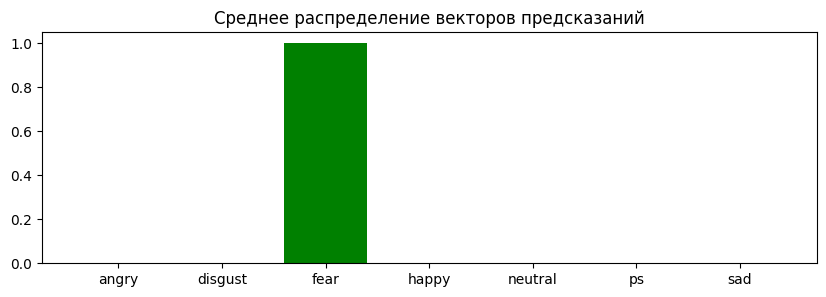

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_mood_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 20ms/step
Классификация сети: fear - ВЕРНО :-)


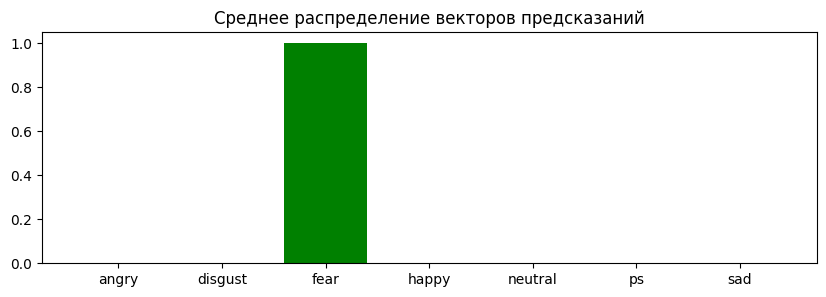

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_hire_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: fear - ВЕРНО :-)


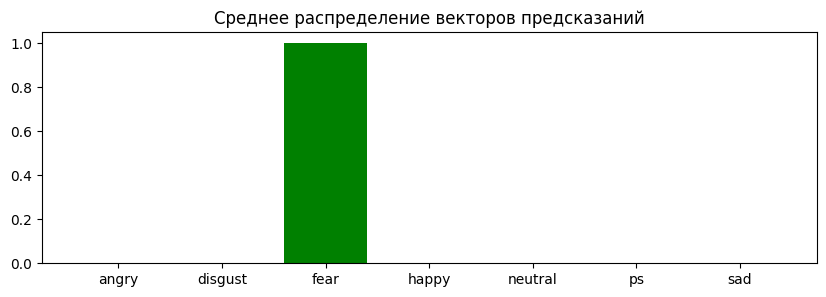

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_whip_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: fear - ВЕРНО :-)


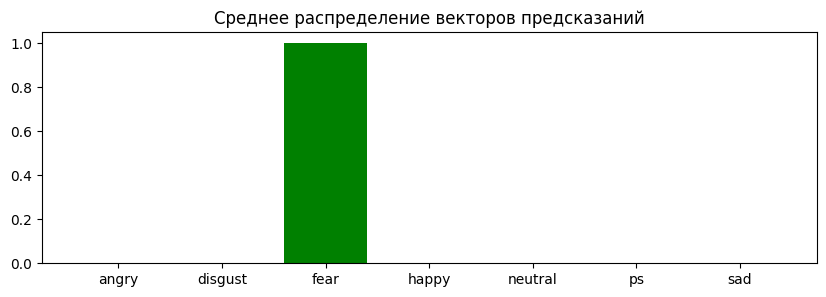

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_live_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: fear - ВЕРНО :-)


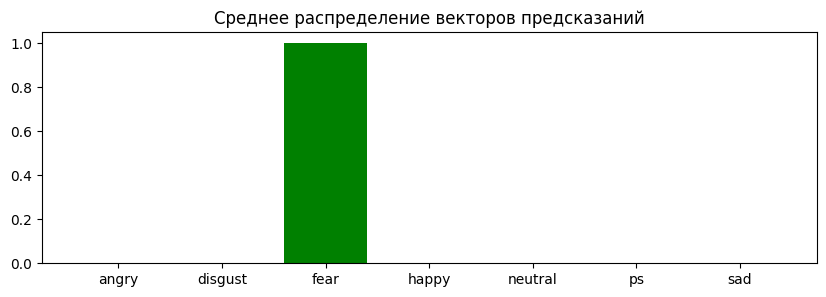

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_when_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: fear - ВЕРНО :-)


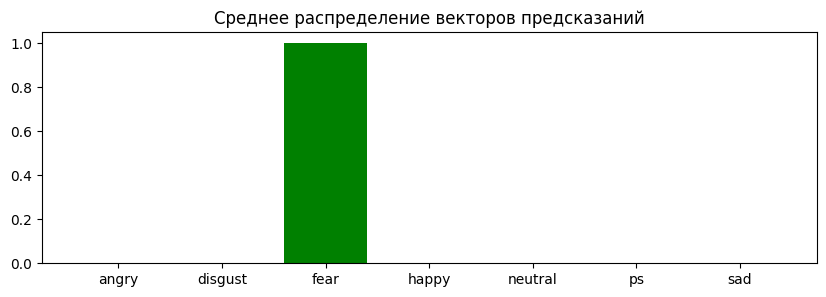

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_hurl_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: fear - ВЕРНО :-)


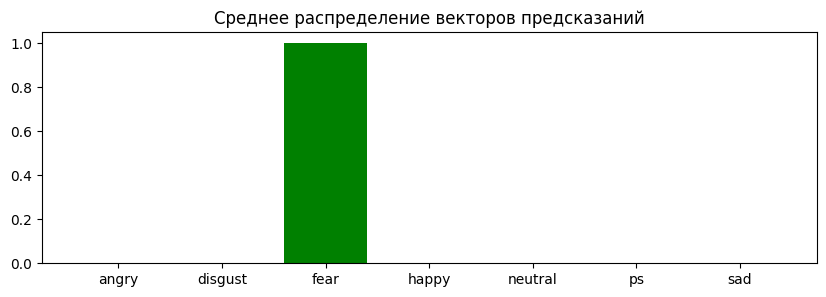

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_keep_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: fear - ВЕРНО :-)


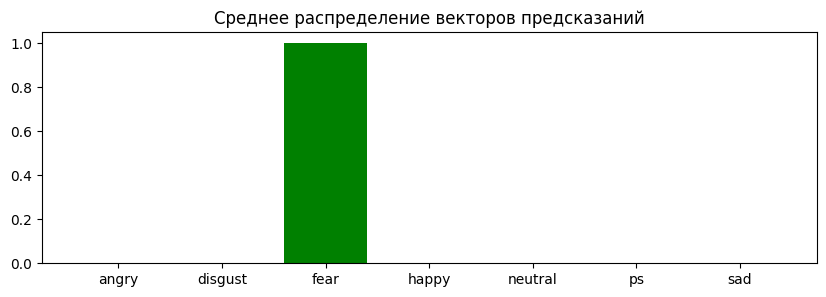

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_thought_fear.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: fear - ВЕРНО :-)


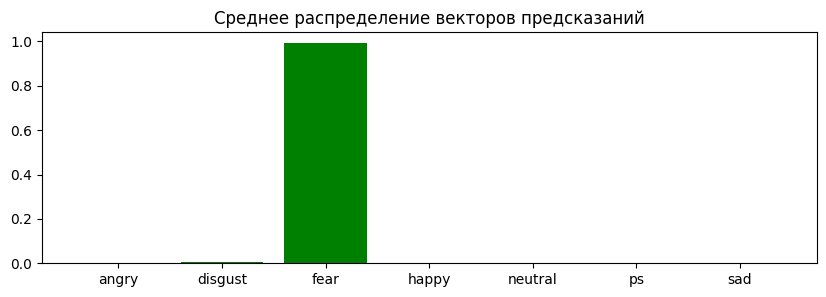

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_deep_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: happy - ВЕРНО :-)


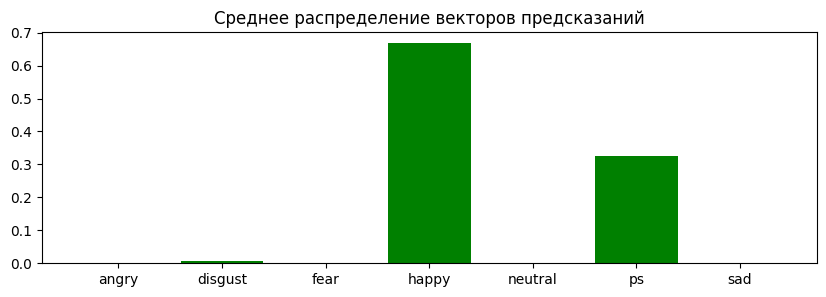

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_chat_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: happy - ВЕРНО :-)


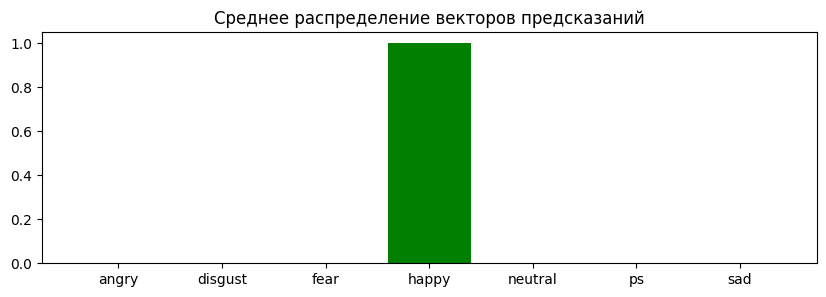

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_room_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: happy - ВЕРНО :-)


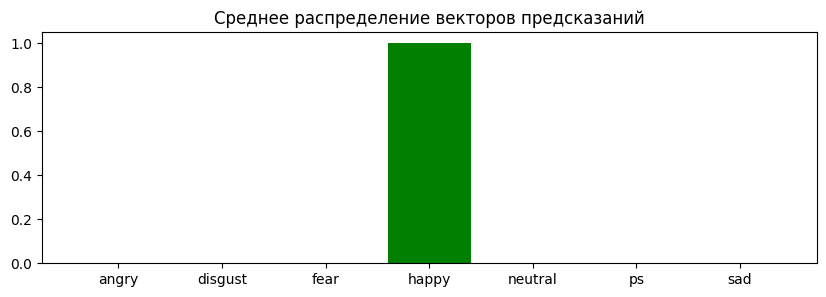

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_mess_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: happy - ВЕРНО :-)


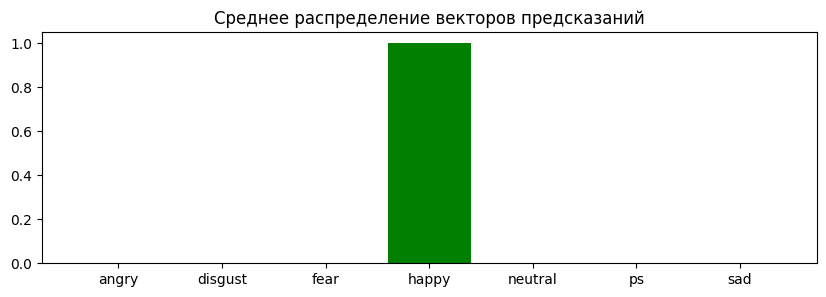

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_gun_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 22ms/step
Классификация сети: happy - ВЕРНО :-)


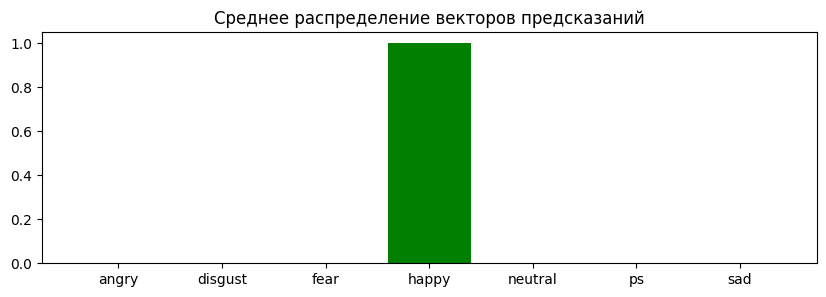

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_mop_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: happy - ВЕРНО :-)


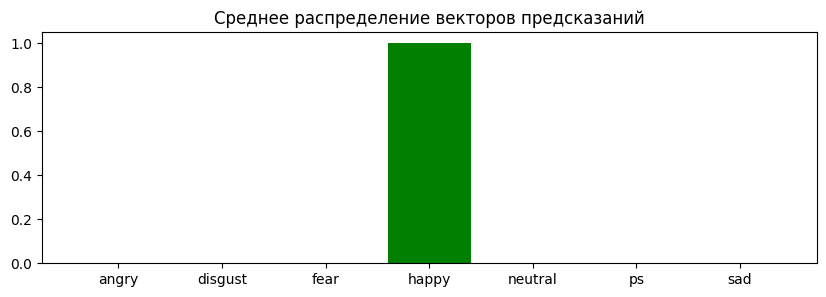

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_life_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: happy - ВЕРНО :-)


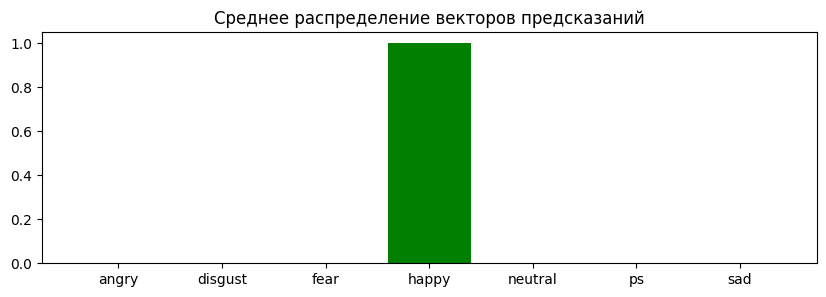

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_bought_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: happy - ВЕРНО :-)


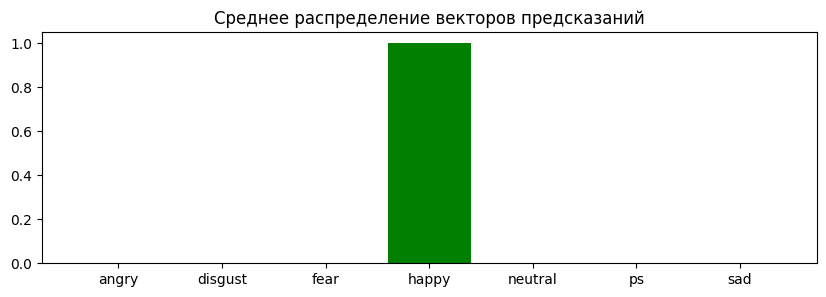

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_wheat_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: happy - ВЕРНО :-)


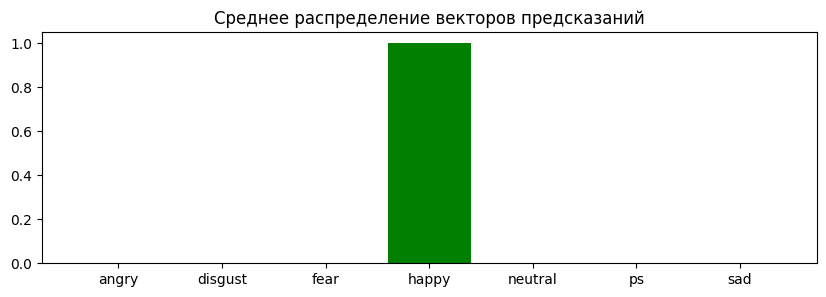

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_chief_happy.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: happy - ВЕРНО :-)


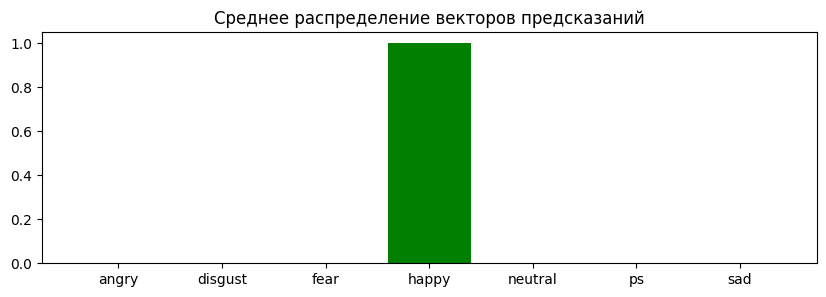

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_pool_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: neutral - ВЕРНО :-)


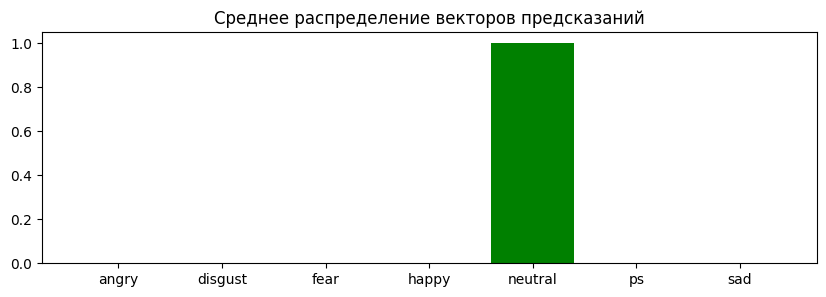

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_tough_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: neutral - ВЕРНО :-)


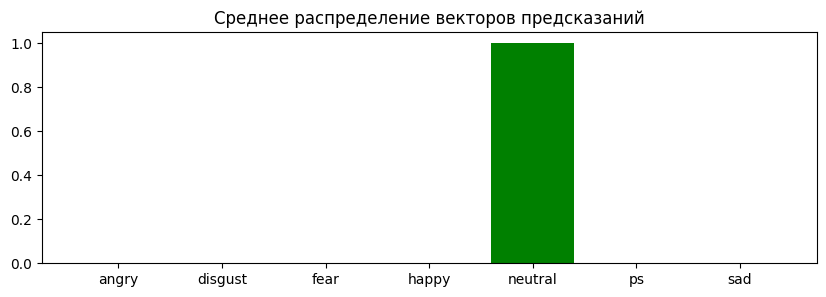

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_young_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 33ms/step
Классификация сети: neutral - ВЕРНО :-)


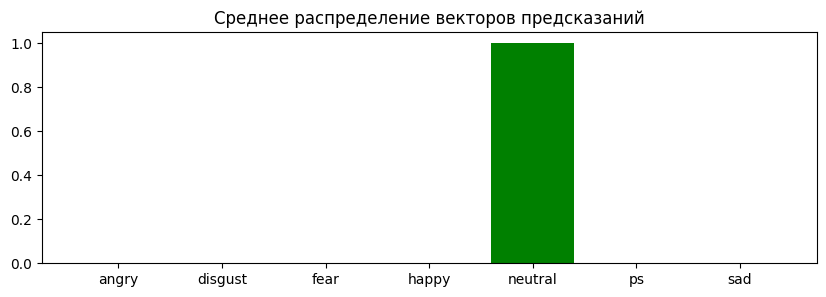

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_wife_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: neutral - ВЕРНО :-)


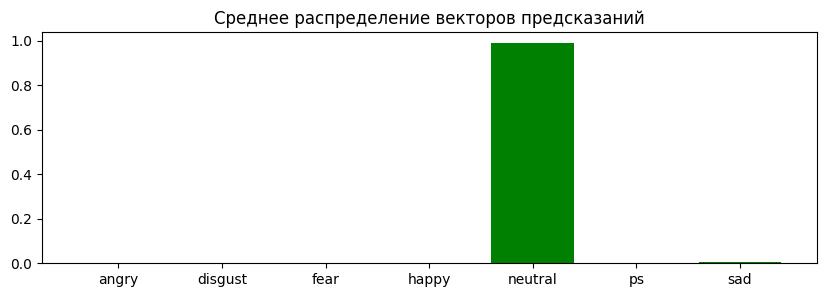

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_choice_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 22ms/step
Классификация сети: neutral - ВЕРНО :-)


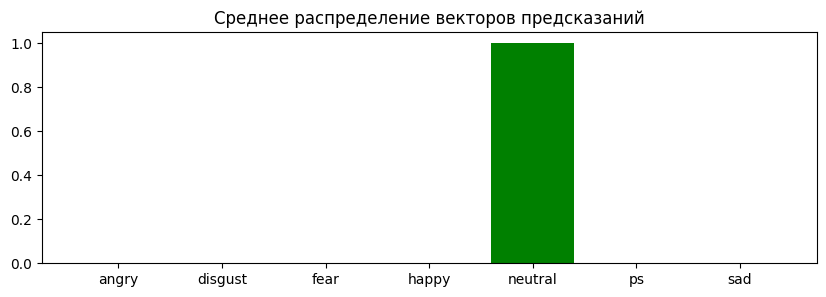

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_food_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: neutral - ВЕРНО :-)


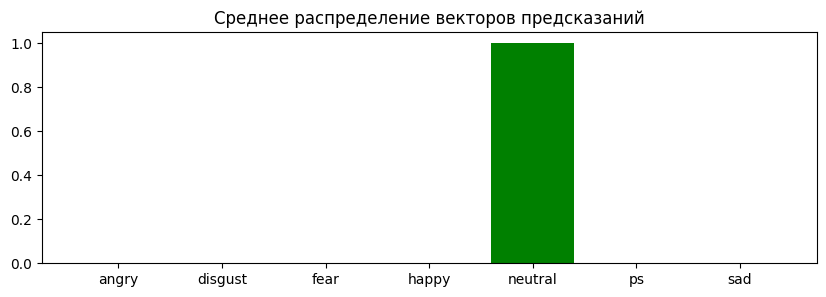

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_door_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: neutral - ВЕРНО :-)


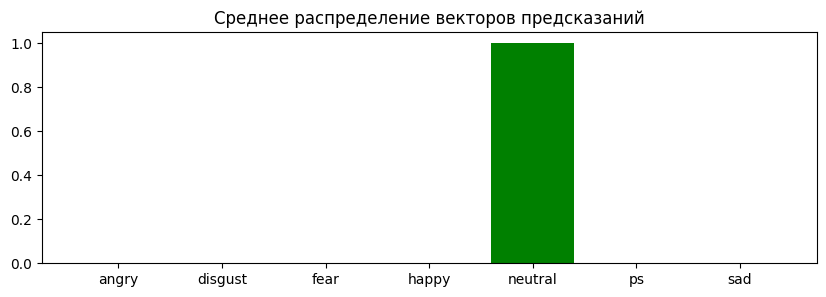

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_long_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: neutral - ВЕРНО :-)


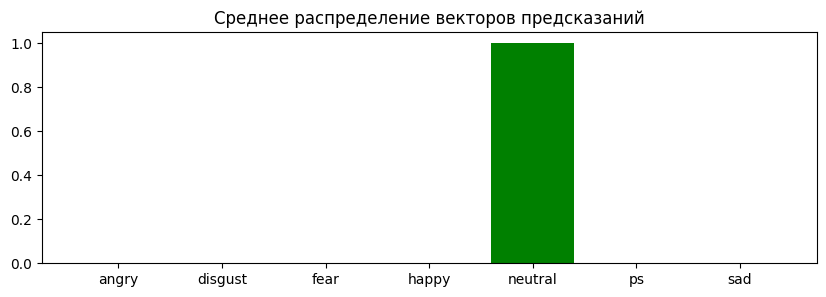

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_near_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: neutral - ВЕРНО :-)


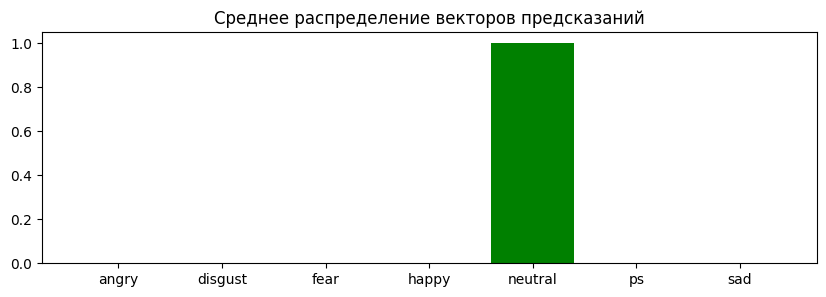

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_vote_neutral.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 37ms/step
Классификация сети: neutral - ВЕРНО :-)


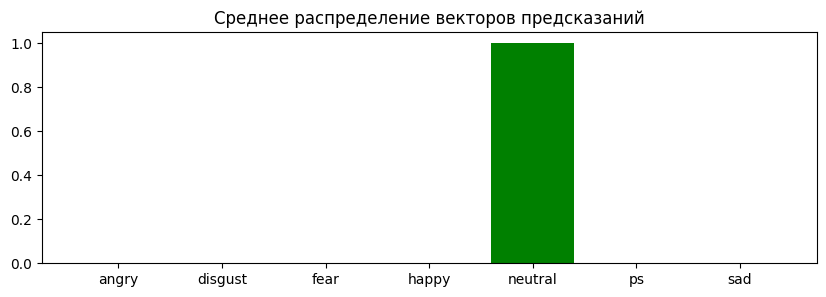

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_luck_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 39ms/step
Классификация сети: ps - ВЕРНО :-)


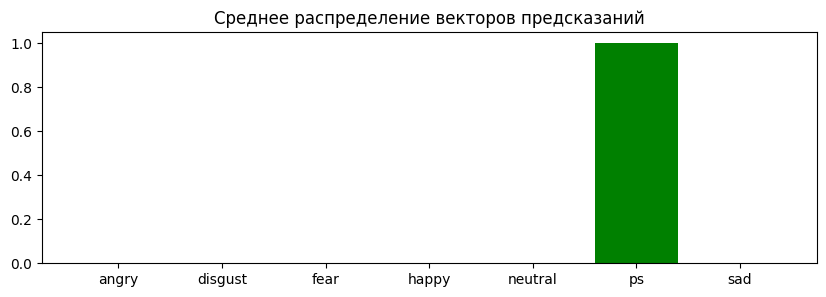

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_soup_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 53ms/step
Классификация сети: ps - ВЕРНО :-)


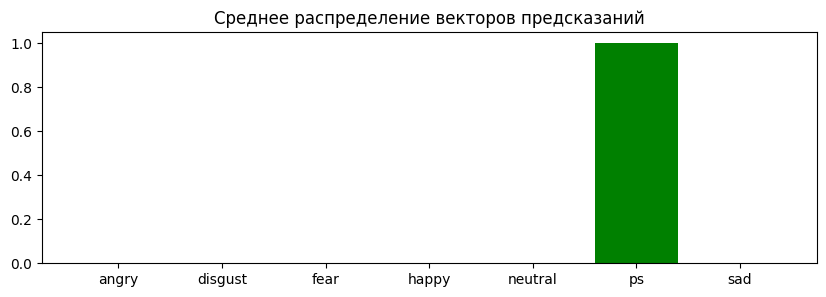

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_rush_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 36ms/step
Классификация сети: ps - ВЕРНО :-)


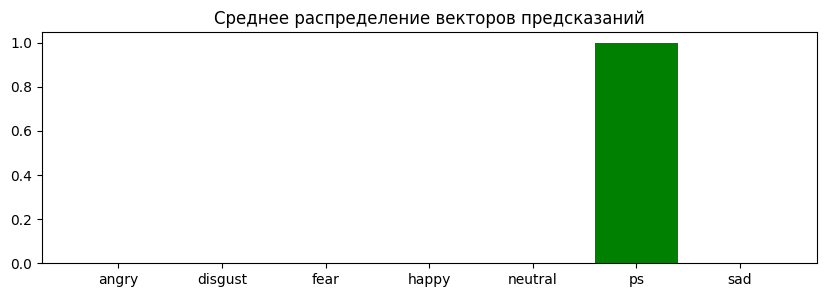

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_kite_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: ps - ВЕРНО :-)


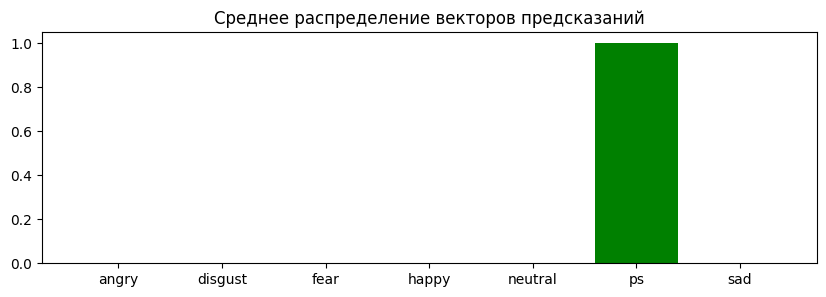

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_rag_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: ps - ВЕРНО :-)


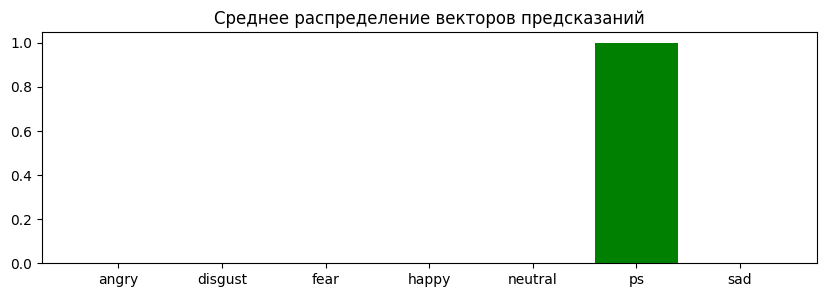

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_pike_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: ps - ВЕРНО :-)


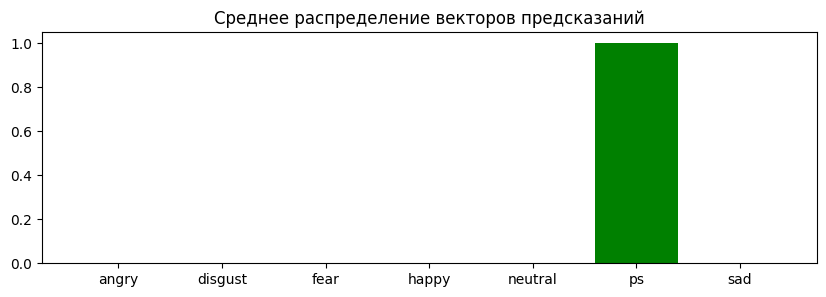

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_hush_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: ps - ВЕРНО :-)


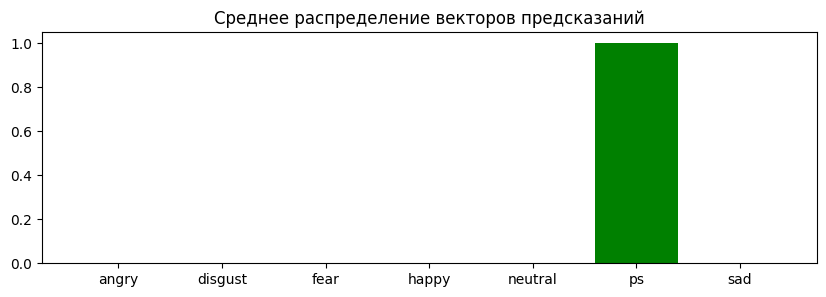

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_gin_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: ps - ВЕРНО :-)


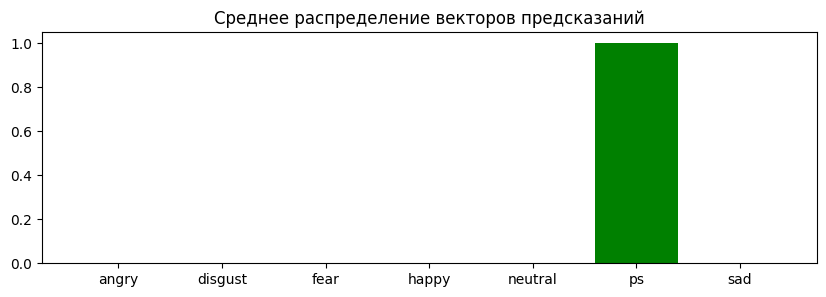

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_jail_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: ps - ВЕРНО :-)


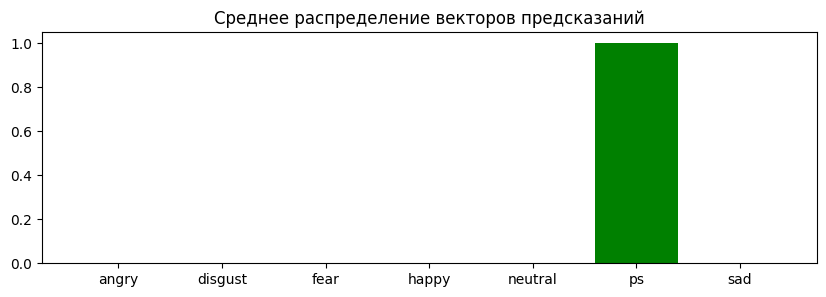

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_long_ps.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 23ms/step
Классификация сети: ps - ВЕРНО :-)


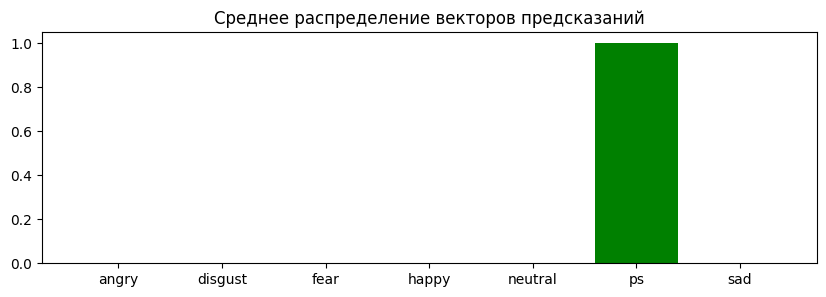

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_king_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: sad - ВЕРНО :-)


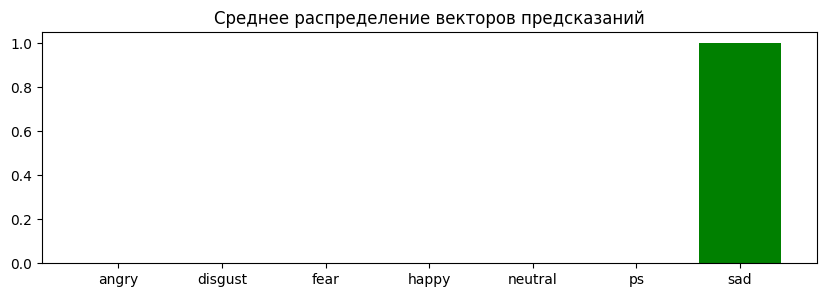

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_gin_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: sad - ВЕРНО :-)


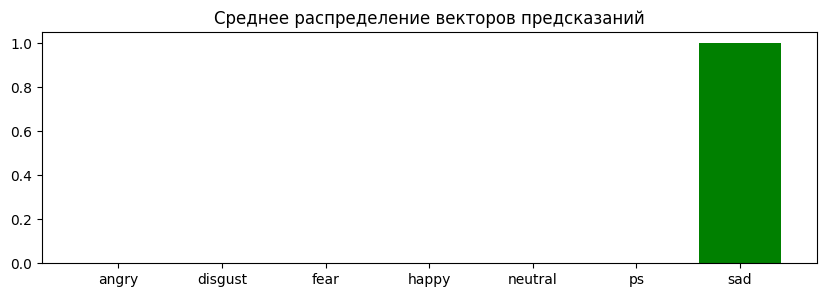

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_read_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: sad - ВЕРНО :-)


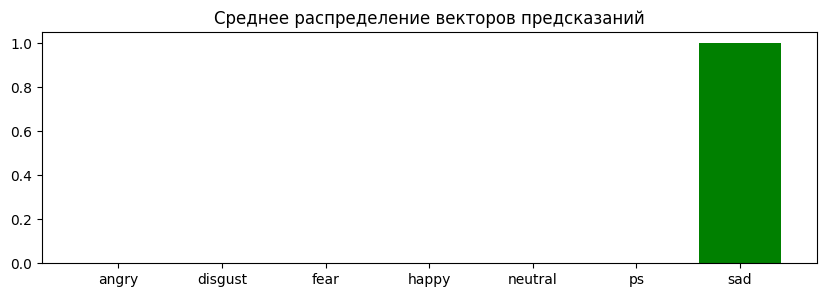

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_wash_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: sad - ВЕРНО :-)


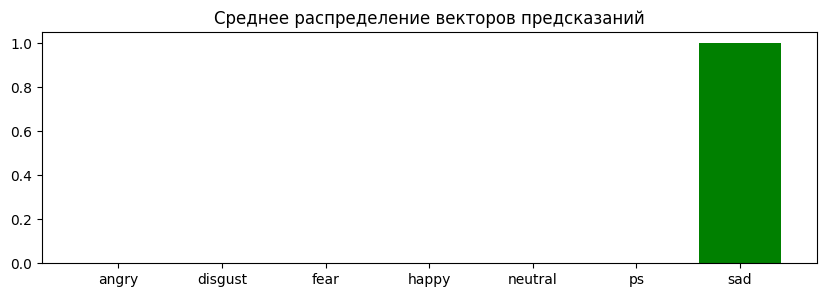

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_book_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: sad - ВЕРНО :-)


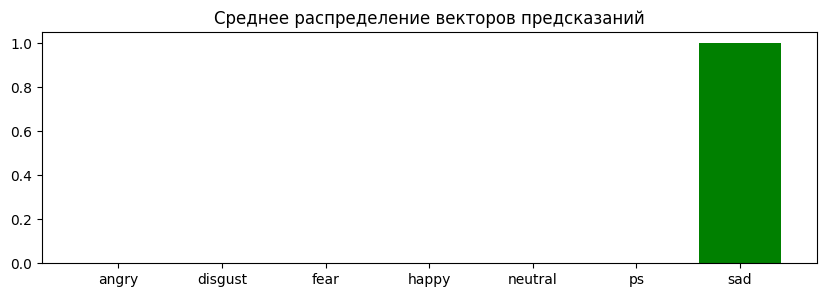

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_met_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: sad - ВЕРНО :-)


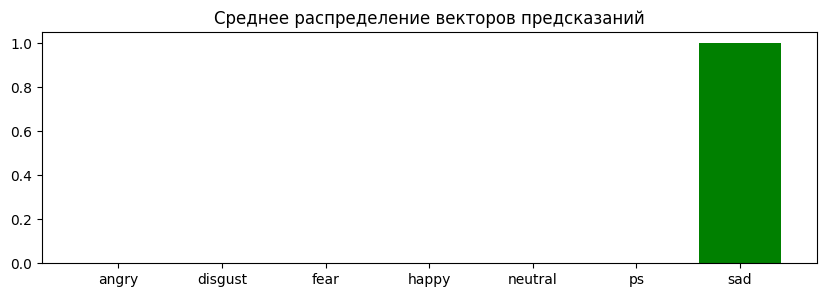

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_jug_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: sad - ВЕРНО :-)


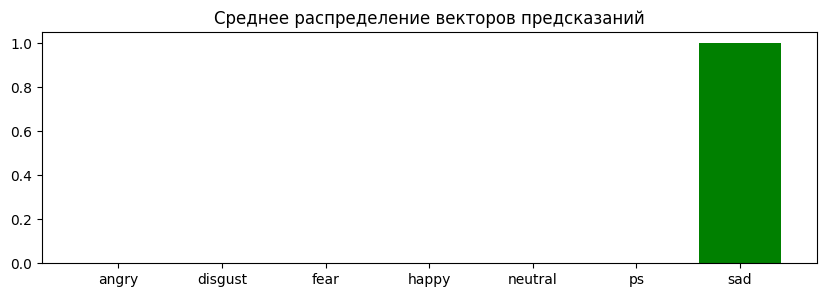

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_hire_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: sad - ВЕРНО :-)


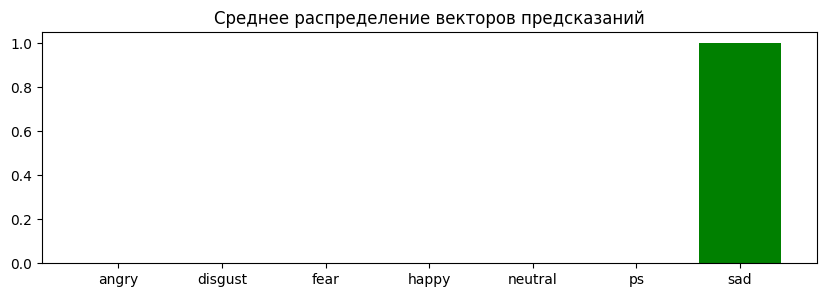

---------------------------------------------------------------
Файл: ./dataverse_files/YAF_void_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 22ms/step
Классификация сети: sad - ВЕРНО :-)


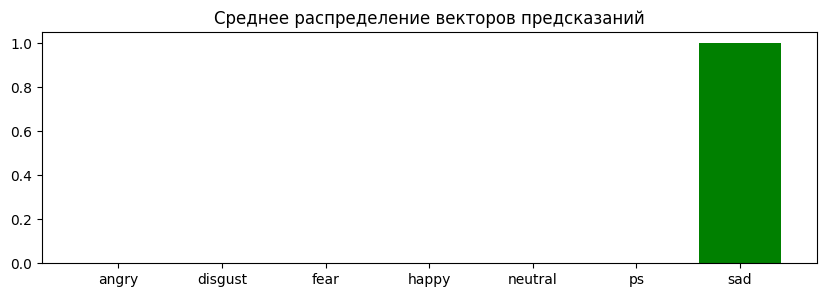

---------------------------------------------------------------
Файл: ./dataverse_files/OAF_sail_sad.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: sad - ВЕРНО :-)


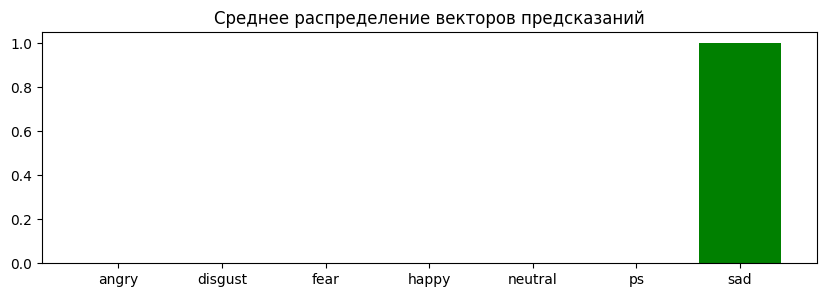

---------------------------------------------------------------
=== Обработано образцов: 70, из них распознано верно: 70, доля верных: 100.0% ===


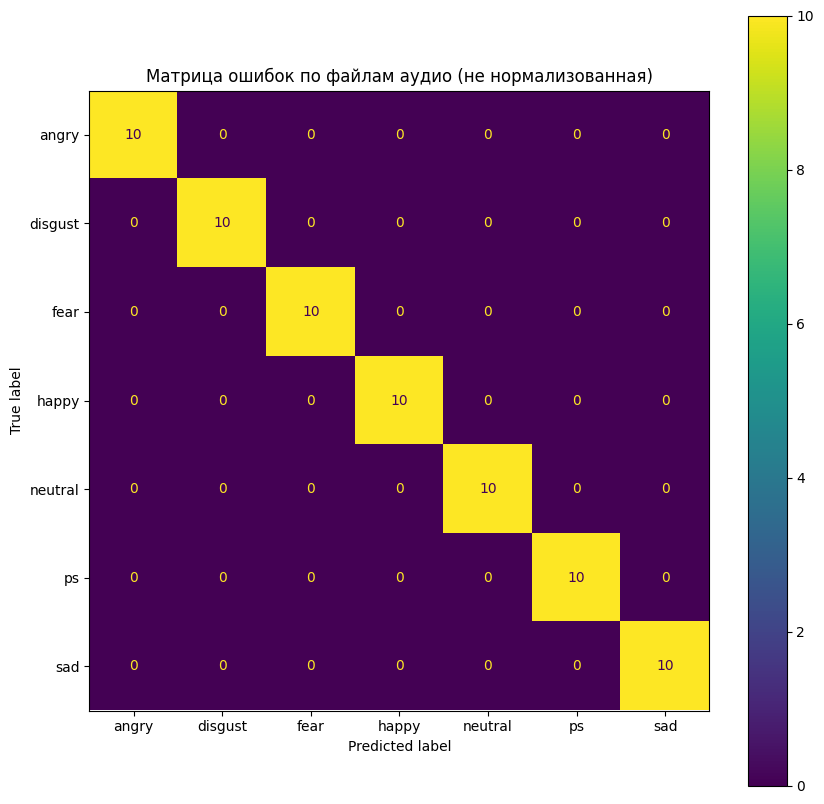

In [ ]:
# Оценка работы модели на тестовых файлах целиком

classify_test_files(model, 350, 10)

## Выводы
Точность почти идеальная

# Прогон на другом датасете

In [ ]:
# Загрузка датасета
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip', None, quiet=True)

'archive.zip'

In [ ]:
!unzip -qo archive.zip -d SAVEE

In [ ]:
SAVEE_SPLIT = 400
SAVEE_FILE_DIR = './SAVEE/ALL'
SAVEE_DATA_LIST = os.listdir(SAVEE_FILE_DIR)

In [ ]:
# Карта соответствия меток  датасета меткам обычным
emo_map = {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'ps'}

In [ ]:
print(len(DATA_NAMES['angry']))
print(DATA_NAMES['angry'][399])

400
OAF_doll_angry.wav


In [ ]:
for class_name in CLASS_LIST:
    for name in SAVEE_DATA_LIST:
        if len(name) == 10:
            emo = emo_map[name[3:4]]
        else:
            emo = emo_map[name[3:5]]

        if class_name == emo:
            DATA_NAMES[class_name].append(name)

In [ ]:
print(len(DATA_NAMES['angry']))
print(DATA_NAMES['angry'][399])

460
OAF_doll_angry.wav


Файл: ./SAVEE/ALL/JK_a04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: ps - НЕВЕРНО.


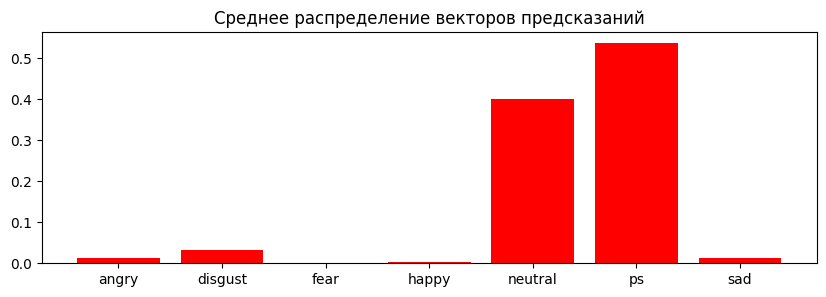

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_a07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: sad - НЕВЕРНО.


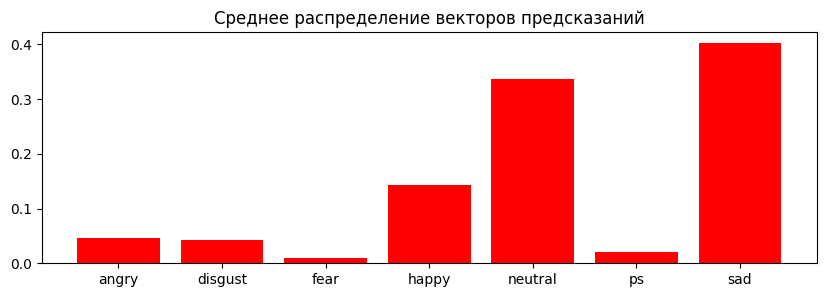

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_a07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: disgust - НЕВЕРНО.


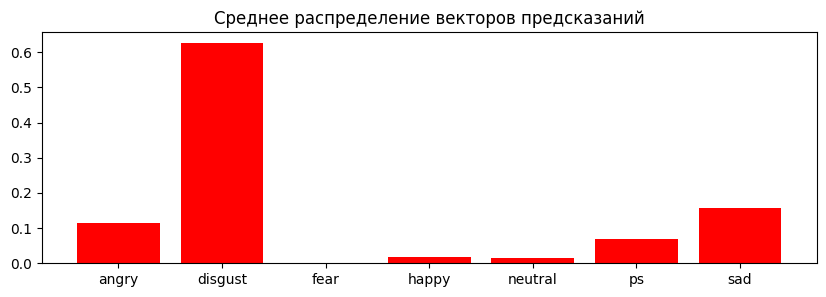

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_a14.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: sad - НЕВЕРНО.


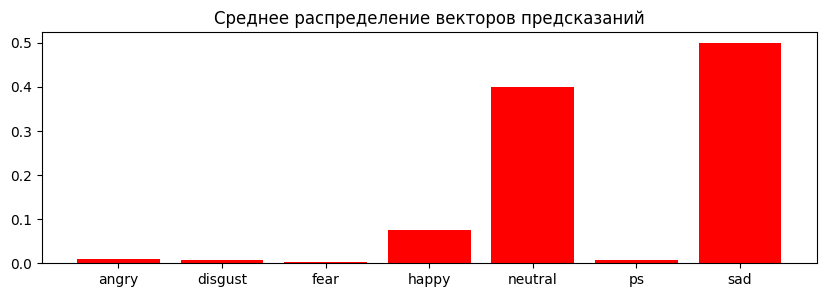

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_a09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: sad - НЕВЕРНО.


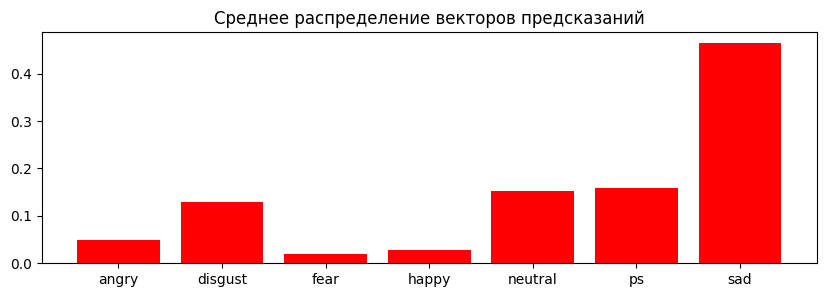

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_a11.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: happy - НЕВЕРНО.


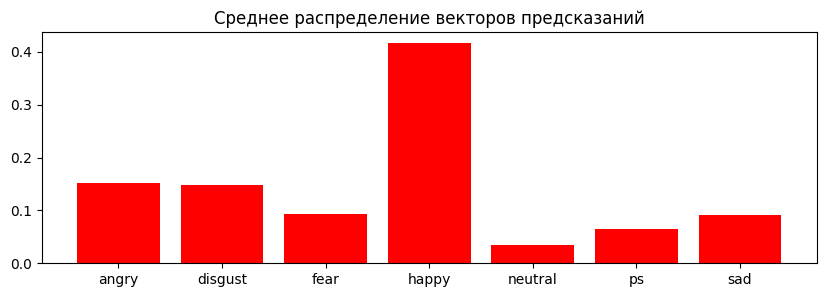

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_a05.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: sad - НЕВЕРНО.


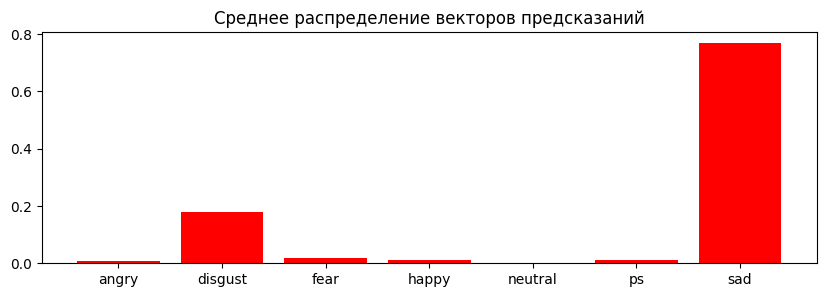

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_a07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 36ms/step
Классификация сети: disgust - НЕВЕРНО.


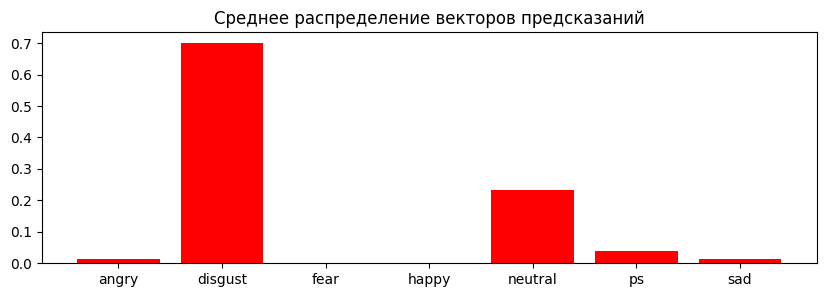

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_a01.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: disgust - НЕВЕРНО.


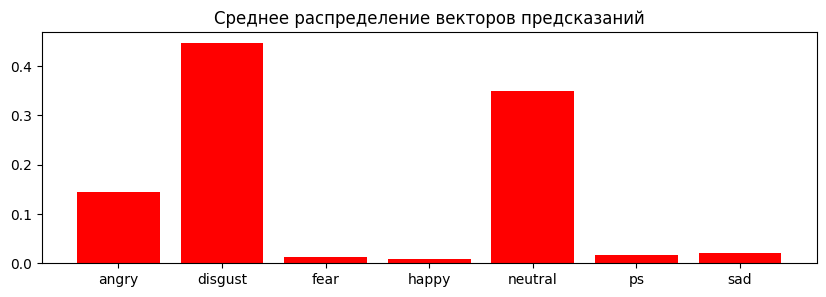

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_a03.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 37ms/step
Классификация сети: neutral - НЕВЕРНО.


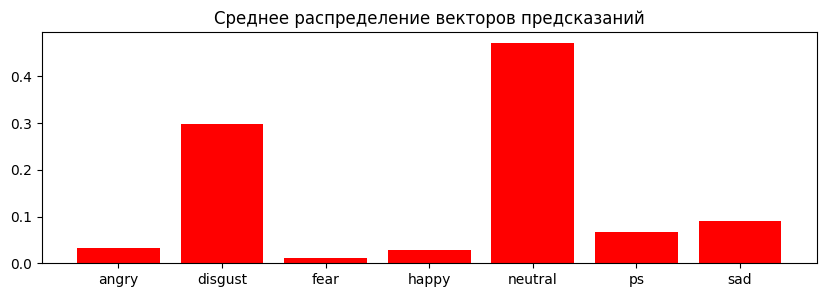

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_d09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: neutral - НЕВЕРНО.


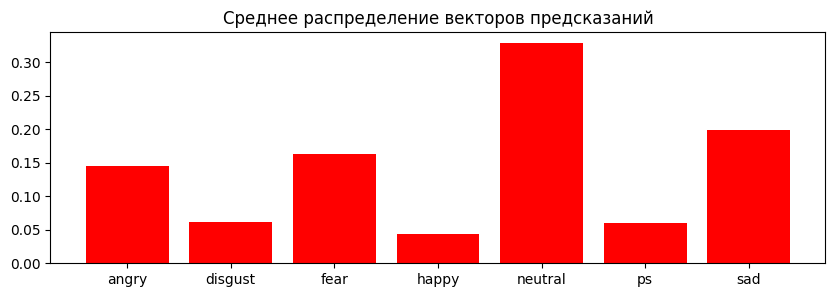

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_d02.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: sad - НЕВЕРНО.


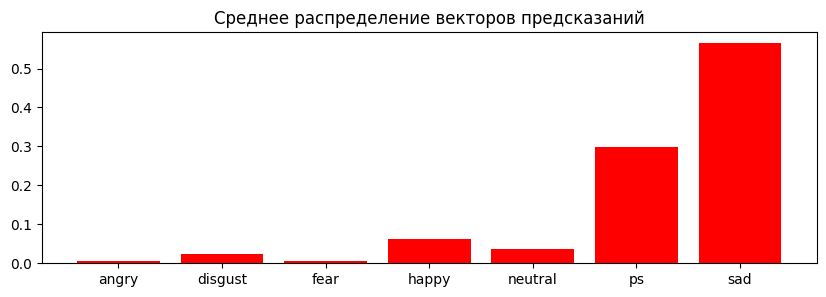

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_d04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: neutral - НЕВЕРНО.


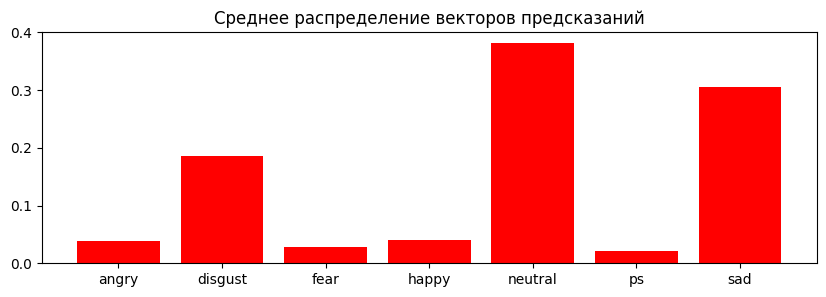

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_d09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: neutral - НЕВЕРНО.


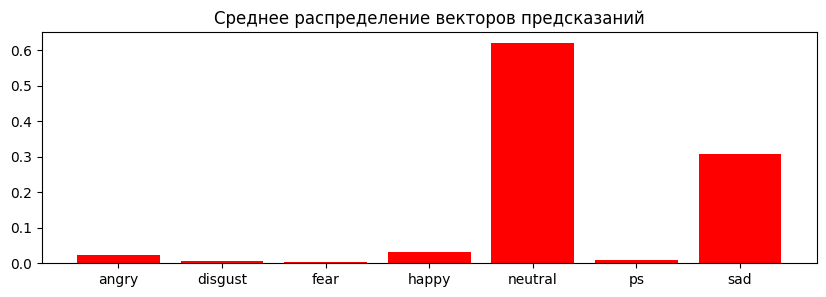

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_d10.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: disgust - ВЕРНО :-)


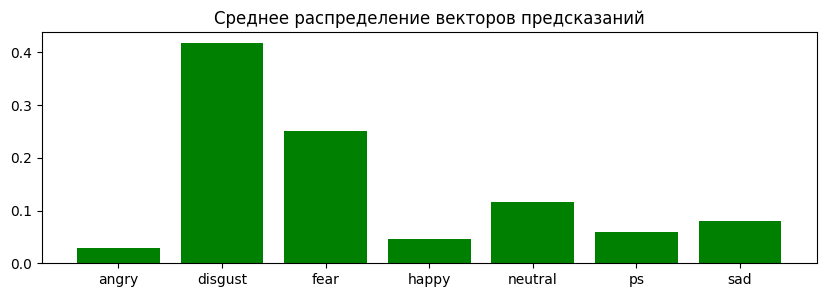

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_d09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: sad - НЕВЕРНО.


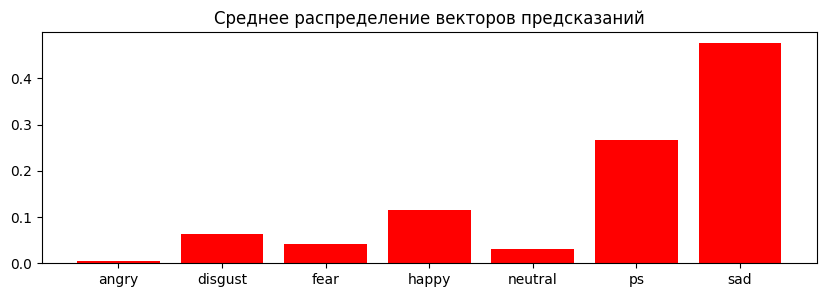

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_d11.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: sad - НЕВЕРНО.


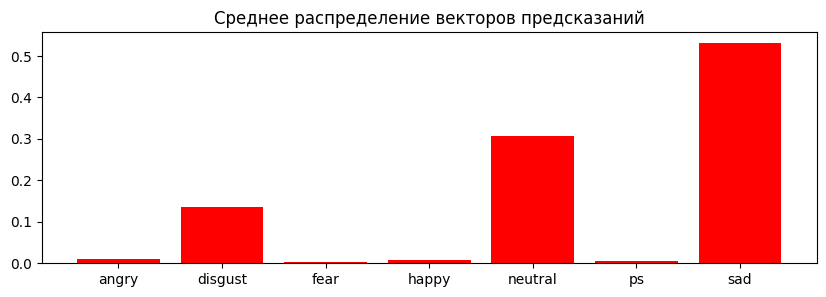

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_d08.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: neutral - НЕВЕРНО.


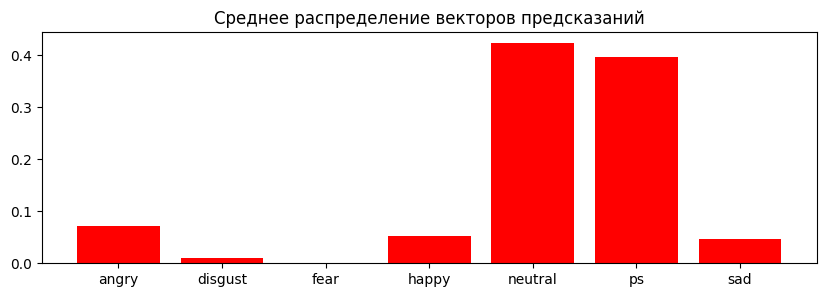

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_d07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 47ms/step
Классификация сети: ps - НЕВЕРНО.


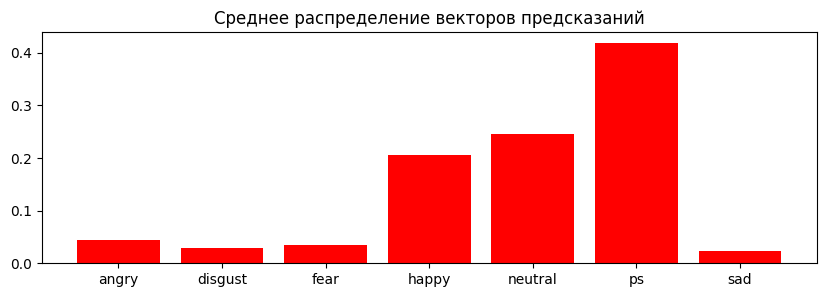

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_d06.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 36ms/step
Классификация сети: ps - НЕВЕРНО.


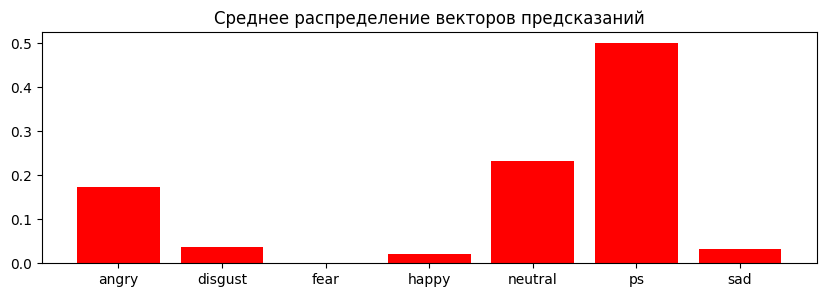

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f12.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 33ms/step
Классификация сети: happy - НЕВЕРНО.


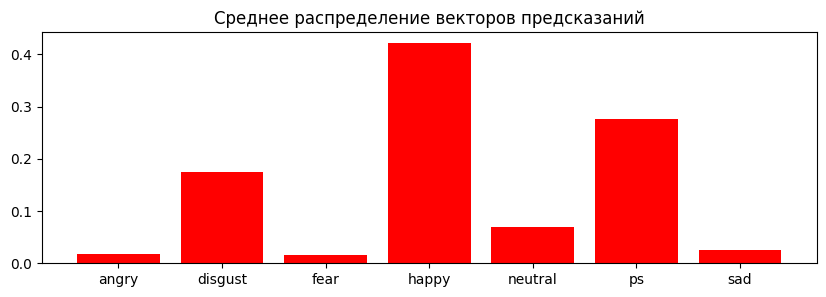

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_f14.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: neutral - НЕВЕРНО.


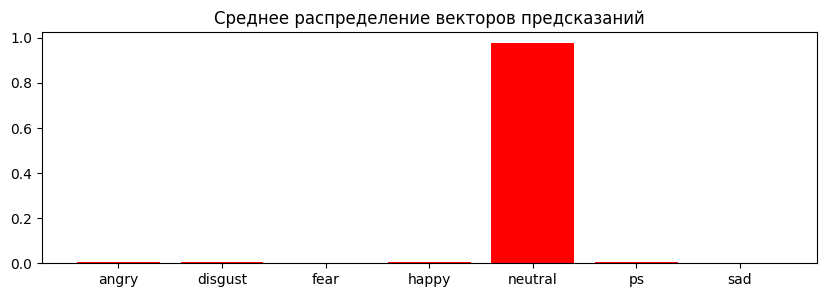

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 30ms/step
Классификация сети: neutral - НЕВЕРНО.


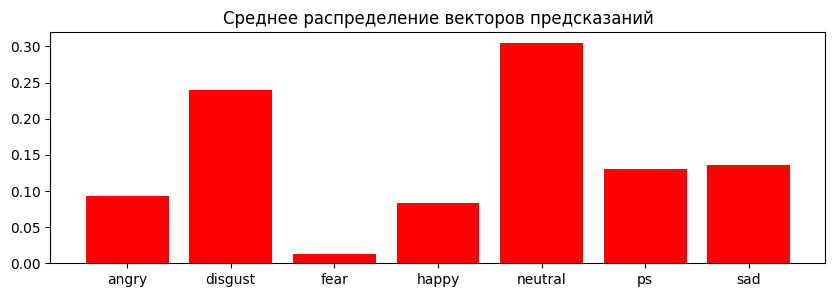

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f13.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 37ms/step
Классификация сети: ps - НЕВЕРНО.


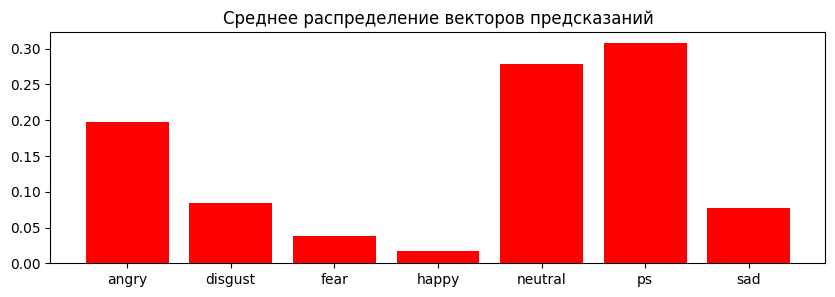

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_f05.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 40ms/step
Классификация сети: neutral - НЕВЕРНО.


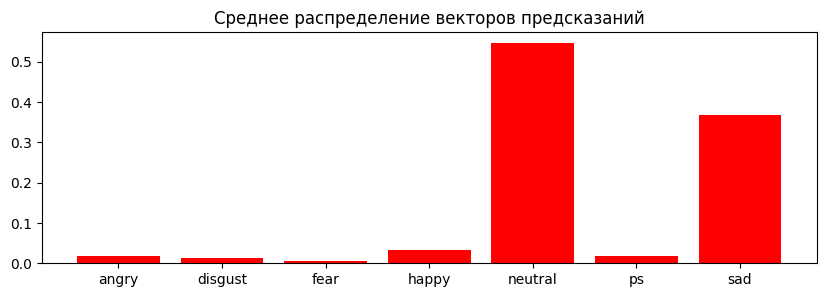

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_f12.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: neutral - НЕВЕРНО.


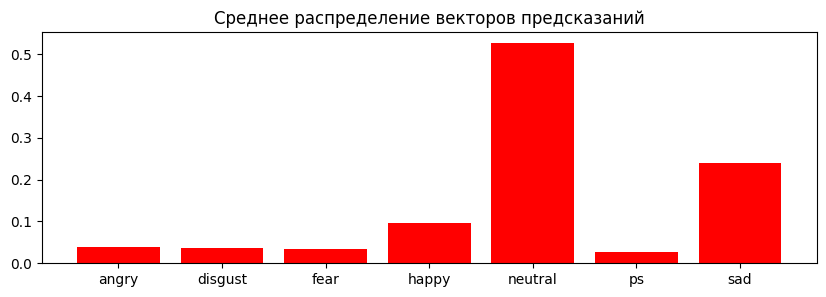

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f08.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: ps - НЕВЕРНО.


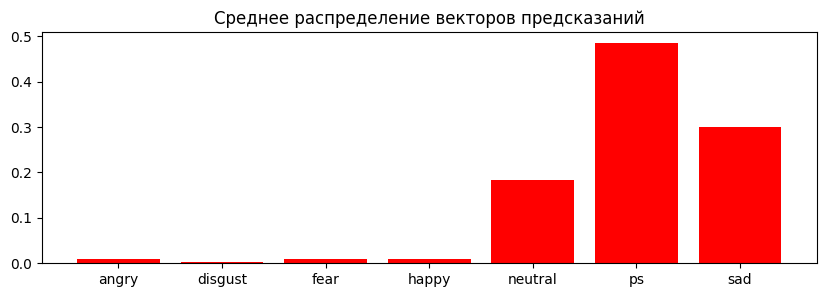

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f11.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: neutral - НЕВЕРНО.


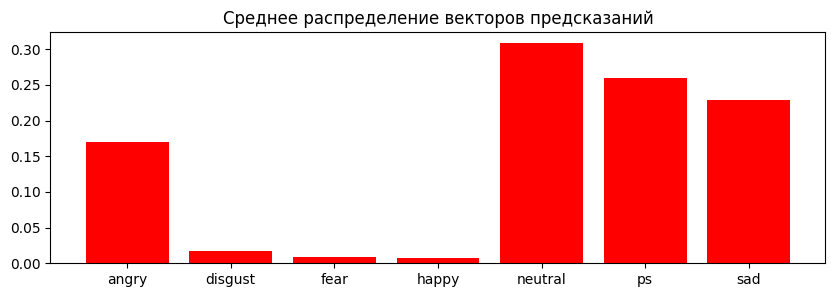

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_f15.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: ps - НЕВЕРНО.


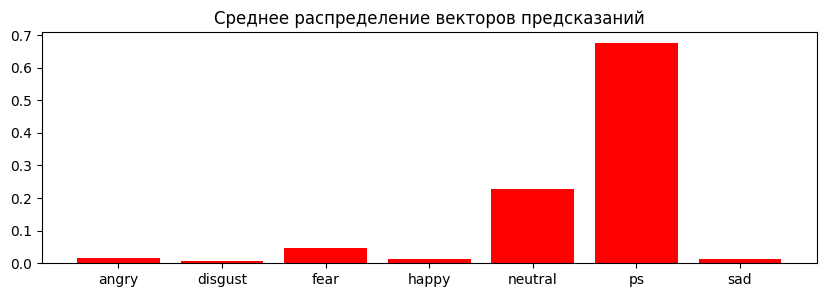

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_f11.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: ps - НЕВЕРНО.


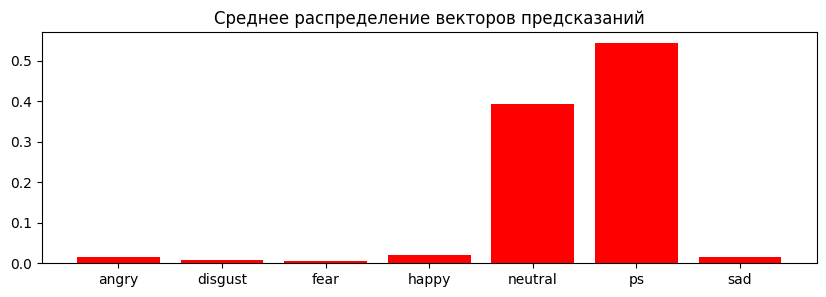

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_h02.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 34ms/step
Классификация сети: happy - ВЕРНО :-)


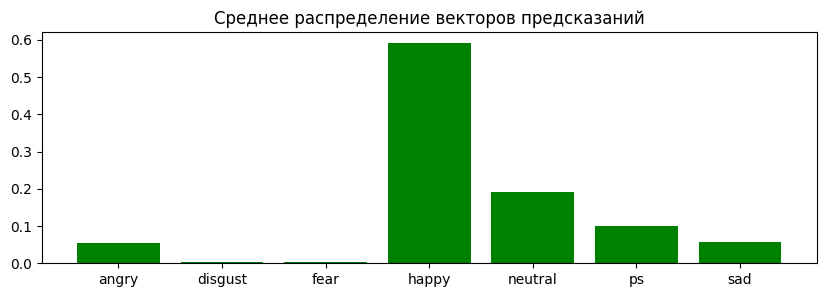

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_h05.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: ps - НЕВЕРНО.


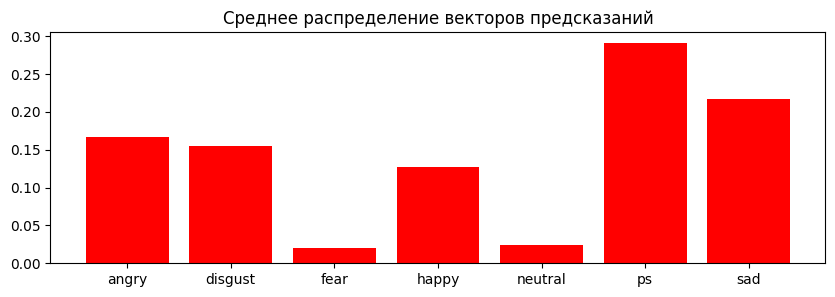

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_h13.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: angry - НЕВЕРНО.


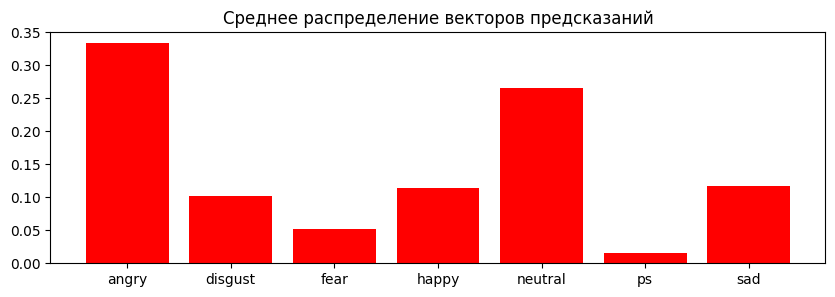

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_h02.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 29ms/step
Классификация сети: sad - НЕВЕРНО.


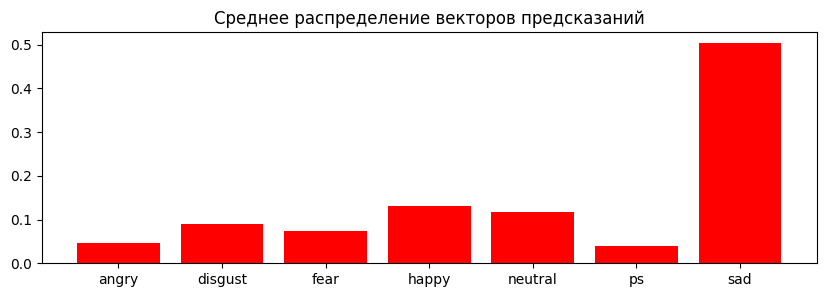

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_h05.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: happy - ВЕРНО :-)


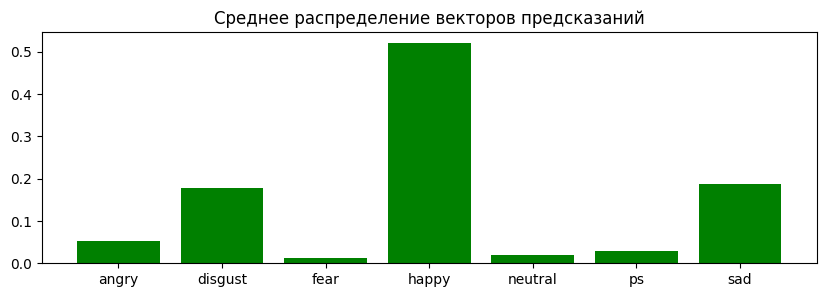

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_h04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 39ms/step
Классификация сети: disgust - НЕВЕРНО.


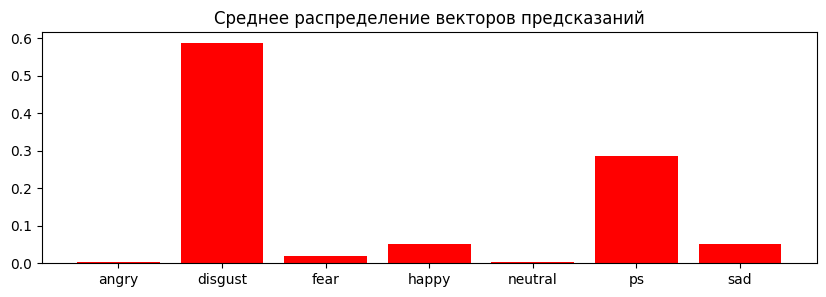

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_h07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: neutral - НЕВЕРНО.


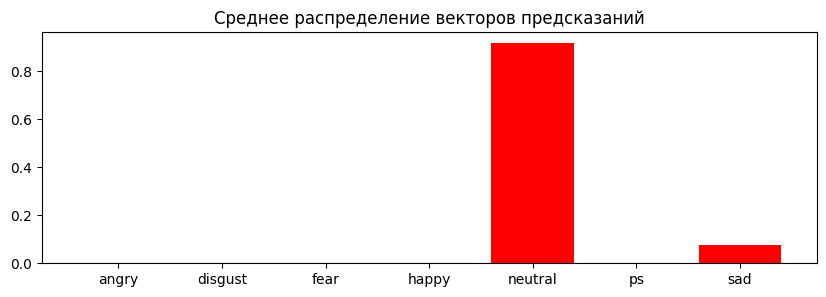

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_h15.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: ps - НЕВЕРНО.


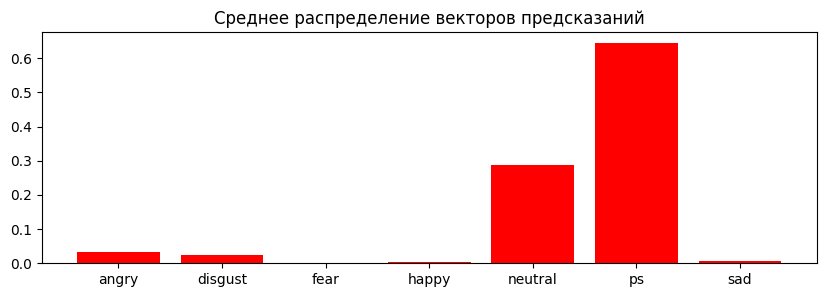

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_h15.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: neutral - НЕВЕРНО.


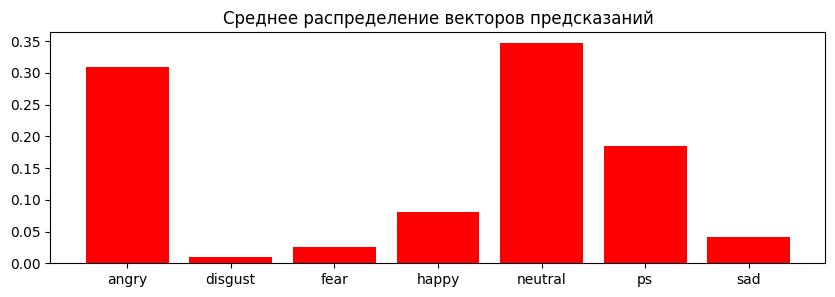

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_h04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: neutral - НЕВЕРНО.


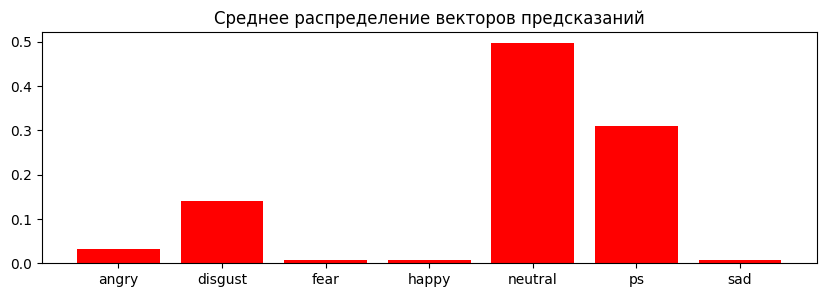

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_n24.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: neutral - ВЕРНО :-)


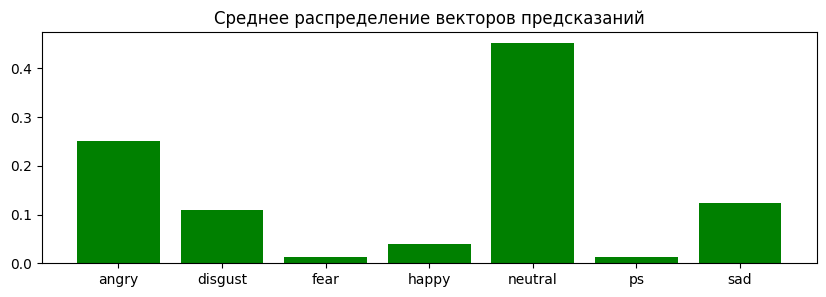

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_n03.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: sad - НЕВЕРНО.


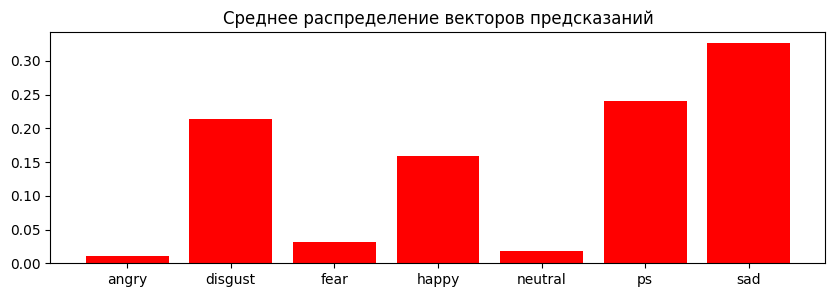

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_n01.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: disgust - НЕВЕРНО.


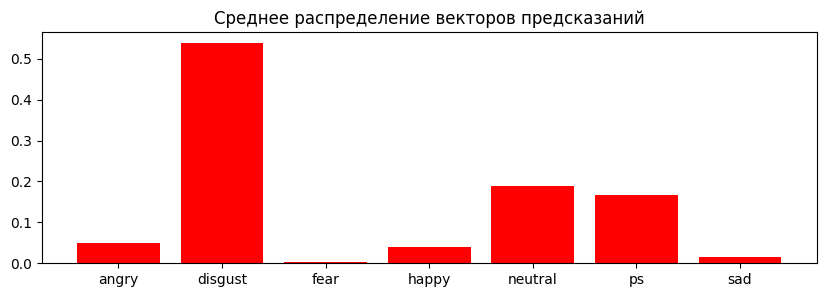

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_n11.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: ps - НЕВЕРНО.


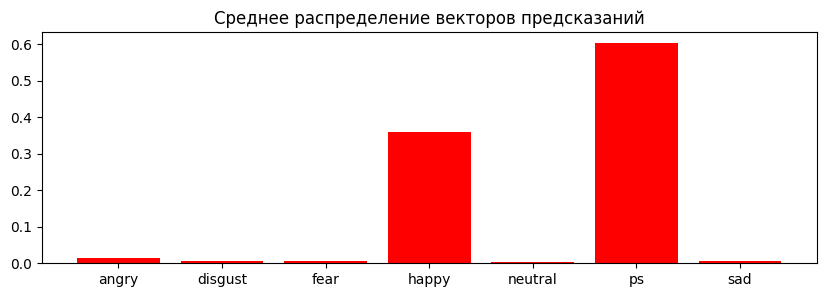

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_n13.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 35ms/step
Классификация сети: ps - НЕВЕРНО.


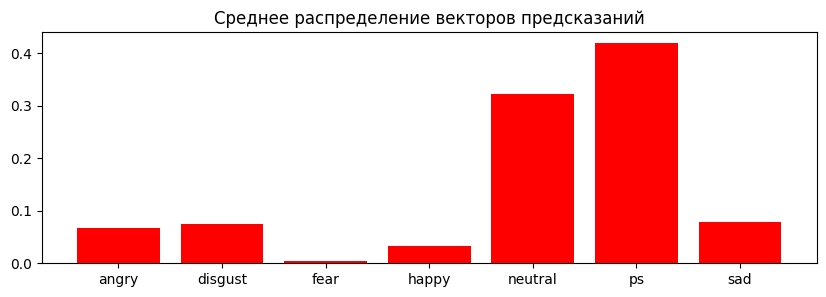

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_n20.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: neutral - ВЕРНО :-)


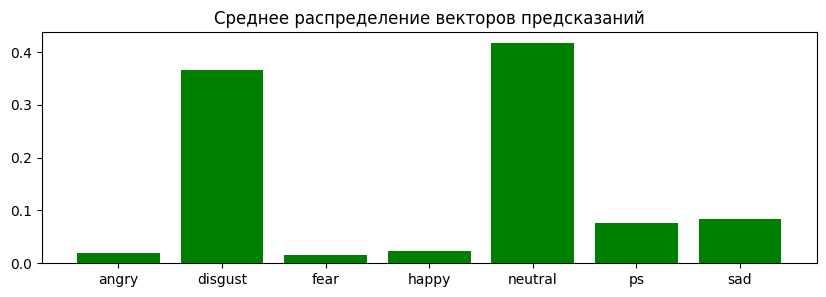

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_n07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 39ms/step
Классификация сети: ps - НЕВЕРНО.


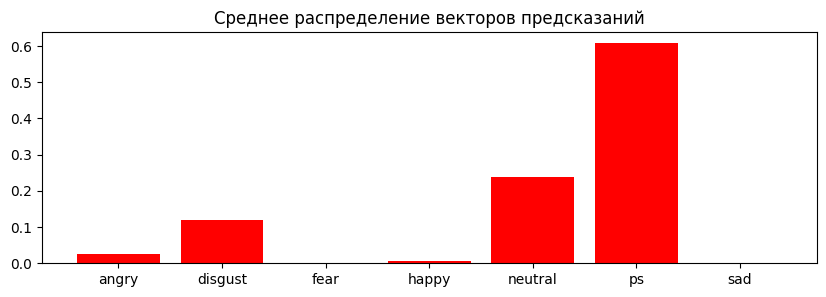

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_n02.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: neutral - ВЕРНО :-)


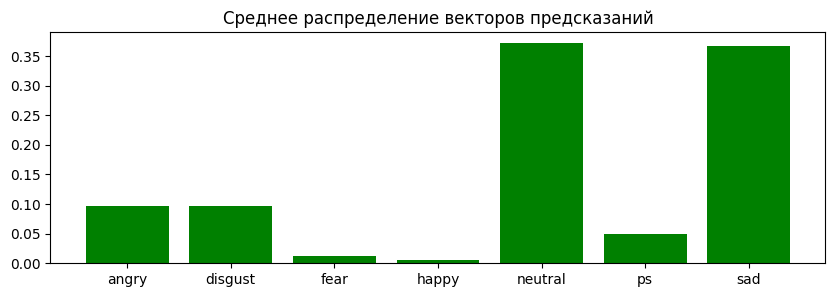

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_n18.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 32ms/step
Классификация сети: ps - НЕВЕРНО.


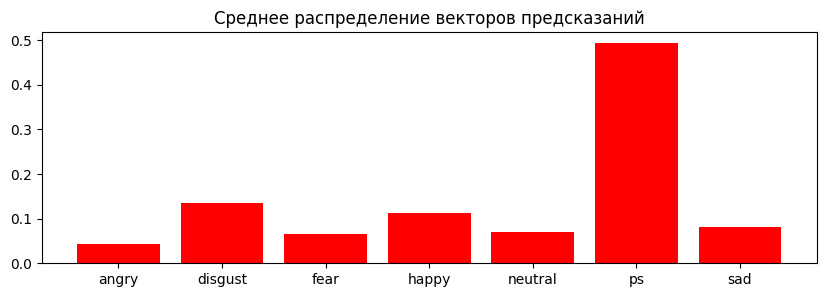

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JE_n03.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 52ms/step
Классификация сети: neutral - ВЕРНО :-)


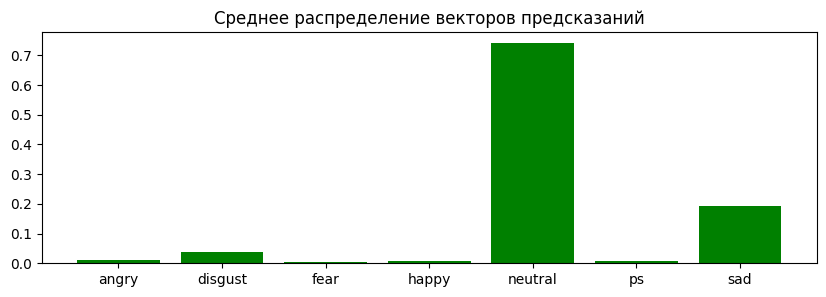

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su15.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 53ms/step
Классификация сети: neutral - НЕВЕРНО.


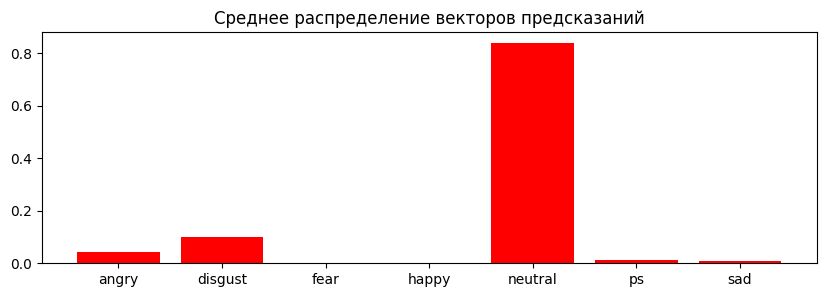

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_su07.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 20ms/step
Классификация сети: happy - НЕВЕРНО.


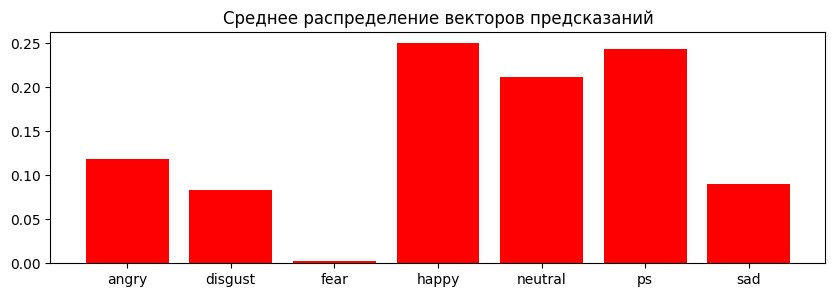

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su08.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 33ms/step
Классификация сети: ps - ВЕРНО :-)


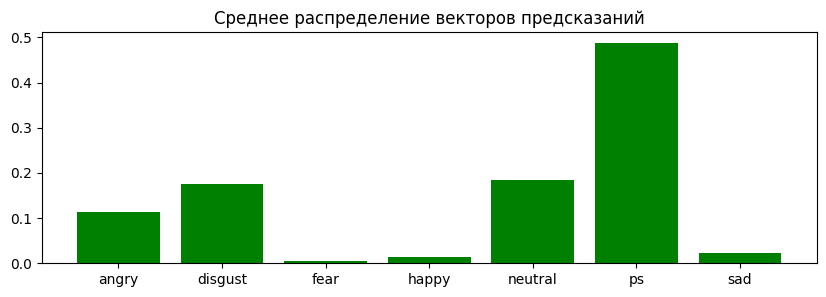

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_su12.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 31ms/step
Классификация сети: ps - ВЕРНО :-)


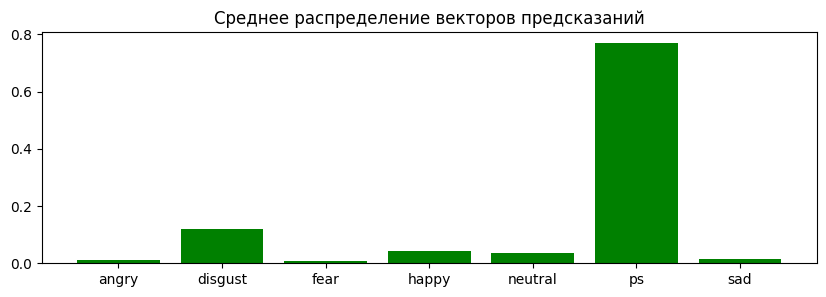

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su03.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: neutral - НЕВЕРНО.


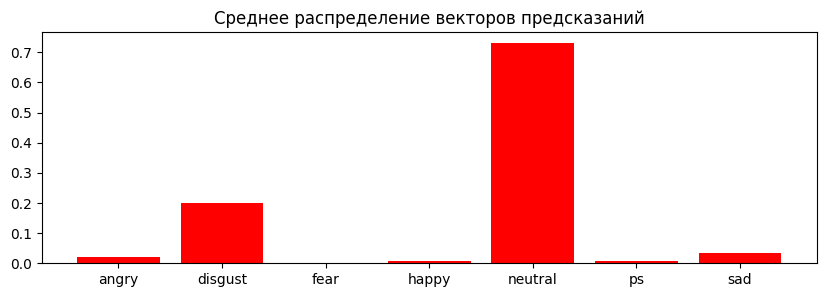

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su04.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 34ms/step
Классификация сети: neutral - НЕВЕРНО.


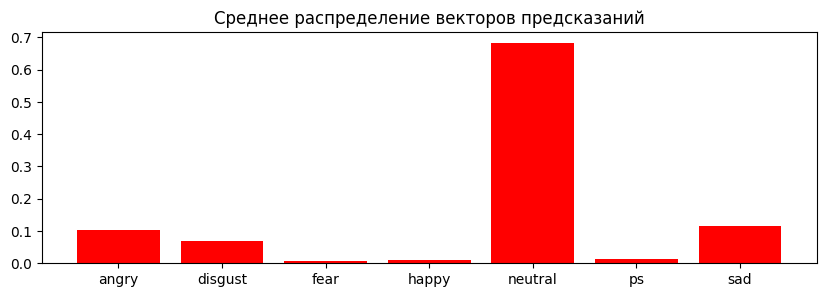

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: disgust - НЕВЕРНО.


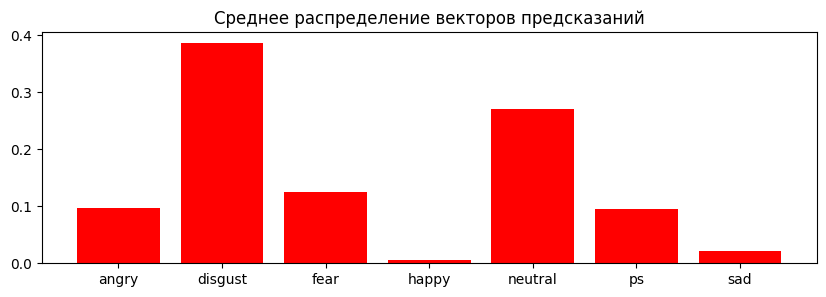

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_su09.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: disgust - НЕВЕРНО.


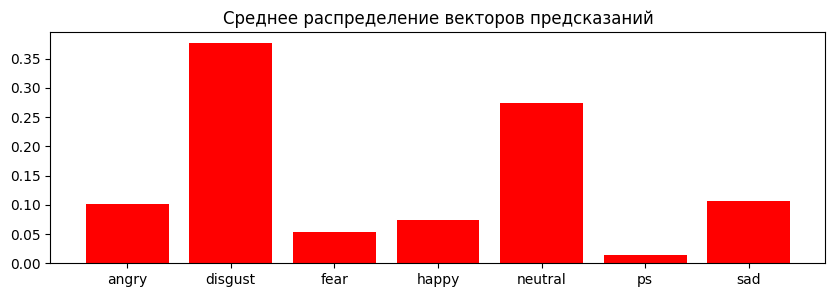

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_su01.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: neutral - НЕВЕРНО.


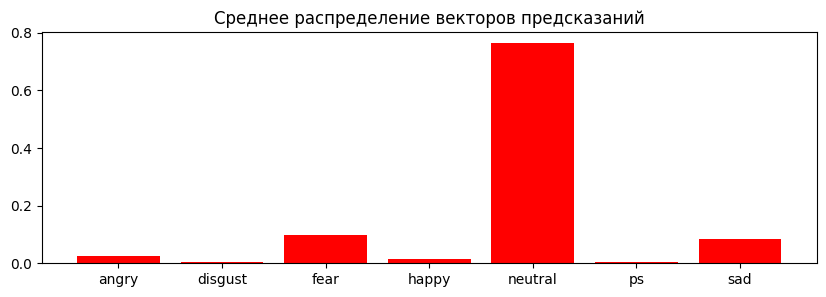

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_su13.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: ps - ВЕРНО :-)


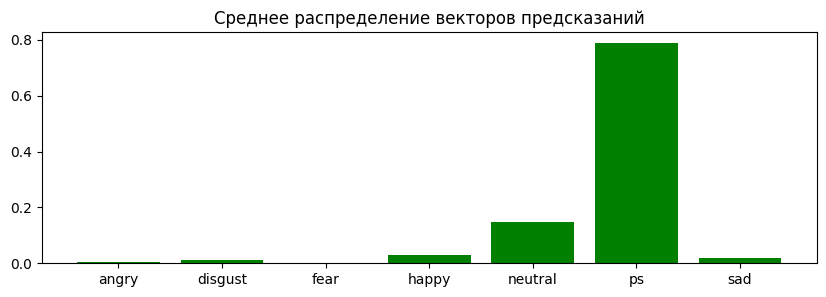

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_sa15.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 25ms/step
Классификация сети: neutral - НЕВЕРНО.


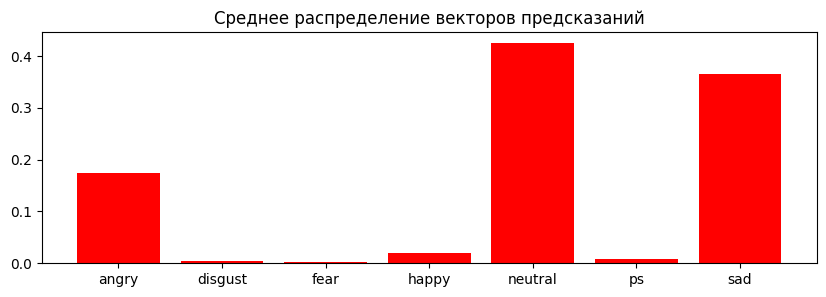

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_sa12.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 27ms/step
Классификация сети: sad - ВЕРНО :-)


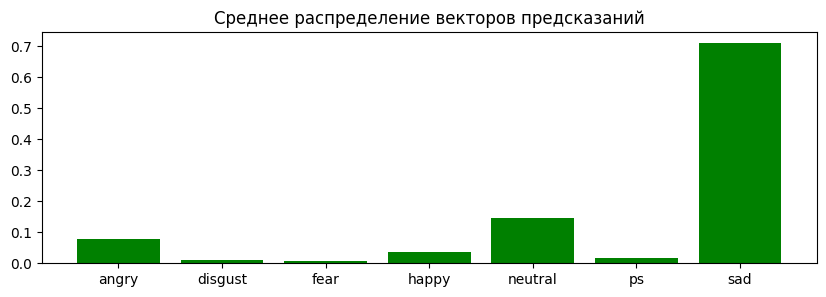

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_sa03.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 28ms/step
Классификация сети: neutral - НЕВЕРНО.


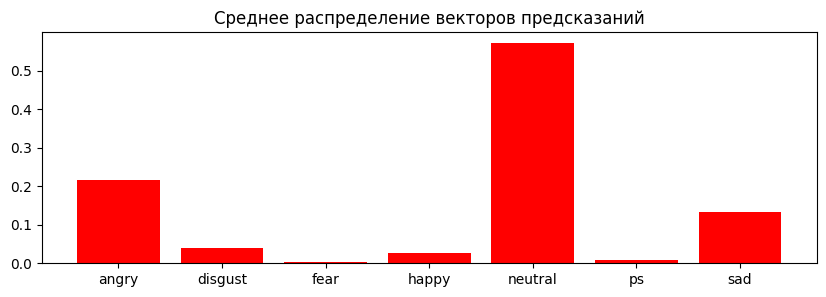

---------------------------------------------------------------
Файл: ./SAVEE/ALL/KL_sa10.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 24ms/step
Классификация сети: neutral - НЕВЕРНО.


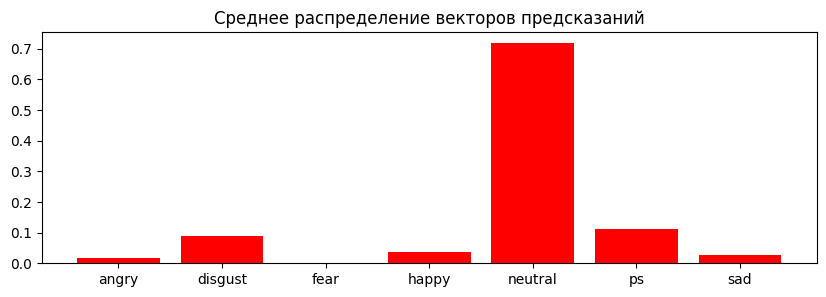

---------------------------------------------------------------
Файл: ./SAVEE/ALL/DC_sa05.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: disgust - НЕВЕРНО.


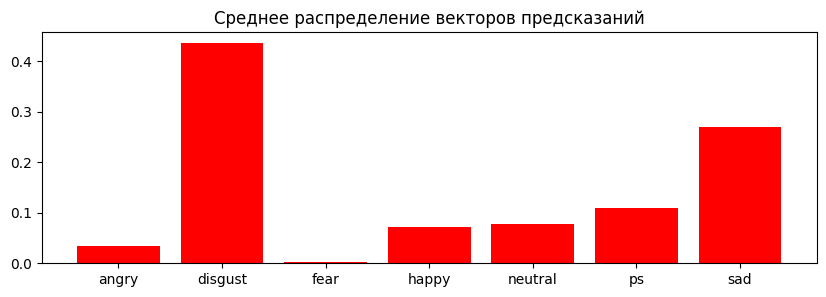

---------------------------------------------------------------
Файл: ./SAVEE/ALL/JK_sa10.wav
Векторы для предсказания: (4, 50, 25)
1/1 [==============================] - 0s 26ms/step
Классификация сети: neutral - НЕВЕРНО.


In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, SAVEE_SPLIT, 10)

# Выводы
Точность намного хуже. Почему?

---

**Выводы:**

1. Спектрально-энергетические параметры речи нового датасета **SAVEE** имеют другие масштабы. Объект-нормировщик **x_scaler** и веса модели к ним не адаптированы;
2. Файлы датасета **SAVEE** оцифрованы с другой частотой дискретизации! Это может влиять на расчеты спектра и потребовать доработки функций извлечения признаков (приведения к единой частоте/ресэмплинга);
3. В датасете **TESS** только два спикера, этого мало для обобщения голосовых параметров эмоции. Стиль речи все-таки у каждого свой, а в **TESS** лишь один мужчина и одна женщина;
4. В датасете **SAVEE** спикеры - только мужчины, это не может не повлиять на точность распознавания;
5. Удалось создать узкоселективный классификатор с хорошей точностью. Но он еще не годится работы с произвольными речевыми данными.

---